In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn import metrics
import matplotlib.pyplot as plt
import numpy as np
from torch.autograd import Variable

In [3]:
class SVBlock(nn.Module):
    def __init__(self, in_channels, out_channels, n_layers, kernel_size=3, **kwargs):
        
        super(SVBlock, self).__init__()
        
        self.device = kwargs['device']
        
        self.convs = nn.ModuleList()
        
        for i in range(n_layers):
            if i == 0:
                _in_channels = in_channels
            else:
                _in_channels = out_channels
                
            self.convs.append(nn.Sequential(
                                    nn.Conv2d(_in_channels, out_channels, kernel_size=kernel_size,
                                              padding=1, stride=1),
                                    nn.BatchNorm2d(out_channels),
                                    nn.ReLU(True)).to(self.device))
            
#         self.convs = nn.Sequential(*self.convs)
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        
    def forward(self, x):
        
        x_prev = self.convs[0](x)
        
        for i in range(1, len(self.convs)):
            x_cur = self.convs[i](x_prev)
            x_prev = x_cur + x_prev
        
        x_out = self.maxpool(x_prev)
        
        return x_out

In [4]:
class Cropping(nn.Module):
    
    def __init__(self, in_size, out_size):
        
        super(Cropping, self).__init__()
        
        crop_range = - (out_size - in_size)
        
        self.out_size = out_size
        
        if crop_range % 2:
            self.crop_x = crop_range // 2
            crop_y = crop_range // 2
        else:
            self.crop_x = crop_range // 2 + 1
            crop_y = (crop_range // 2)
            
    def forward(self, x):
        crop = x[:, :, self.crop_x : self.crop_x + self.out_size, self.crop_x : self.crop_x + self.out_size]
        
        return crop

In [5]:
class SkippedVGG(nn.Module):
    
    def __init__(self, **kwargs):
        
        super(SkippedVGG, self).__init__()
        
        self.device = kwargs['device']
        
        self.sv0 = SVBlock(1, 64, 2, device=self.device).to(self.device)
        self.sv1 = SVBlock(64, 128, 2, device=self.device).to(self.device)
        self.sv2 = SVBlock(192, 256, 3, device=self.device).to(self.device)
        
        self.crop0_2 = Cropping(24, 12)
        self.crop0_out = Cropping(24, 6)
        self.crop1_out = Cropping(12, 6)
        
        self.classifier = nn.Sequential(nn.Linear(448, 7), nn.BatchNorm1d(7)).to(self.device)
        
    def forward(self, x):
        x0 = self.sv0(x)
        x1 = self.sv1(x0)
        
        x_crop0_2 = self.crop0_2(x0)
        x2 = torch.cat([x1, x_crop0_2], dim=1)
        
        x2 = self.sv2(x2)
        
        x_crop0_out = self.crop0_out(x0)
        x_crop1_out = self.crop1_out(x1)
        x3 = torch.cat([x2, x_crop0_out, x_crop1_out], dim=1)
       
        x_out = nn.AvgPool2d(kernel_size=(x3.size(-2), x3.size(-1)))(x3)
        x_out = nn.Flatten()(x_out)
        
        x_out = self.classifier(x_out)
        
        return x_out

In [6]:
import torch
from torchvision import transforms, datasets

data_transform = transforms.Compose([
        transforms.Grayscale(num_output_channels=1),
#         transforms.Lambda(lbp_transform),
#         transforms.Lambda(combine_lbp_hog),
#         transforms.ToPILImage(),
        # transforms.RandomSizedCrop(224),
#         transforms.RandomHorizontalFlip(),
#         transforms.RandomVerticalFlip(),
#         transforms.RandomRotation(degrees=180),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])

train_fer = datasets.ImageFolder(root='/tf/data/Quan/fer2013/data/train', transform=data_transform)
val_fer = datasets.ImageFolder(root='/tf/data/Quan/fer2013/data/val', transform=data_transform)
test_fer = datasets.ImageFolder(root='/tf/data/Quan/fer2013/data/test', transform=data_transform)

batch_size = 128
train_loader = torch.utils.data.DataLoader(train_fer,
                                             batch_size=batch_size, shuffle=True,
                                             num_workers=8)
val_loader = torch.utils.data.DataLoader(val_fer,
                                             batch_size=batch_size, shuffle=True,
                                             num_workers=8)
test_loader = torch.utils.data.DataLoader(test_fer,
                                             batch_size=batch_size, shuffle=True,
                                             num_workers=8)

In [19]:
device = torch.device('cuda')
print(device)

model = SkippedVGG(device=device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-4)


cuda


In [8]:
model = model.to(device)

model_path = '/tf/data/Quan/fer2013/backtobasics/skippedvgg_3blocks.pt'
best_acc = 0.0
hist = []

for epoch in range(60):  # loop over the dataset multiple times
    
    print('Epoch: ', epoch + 1)
    running_loss = 0.0
    running_acc = 0.0

    # TRAIN
    model.train()
    for i, data in enumerate(train_loader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        acc = float((torch.argmax(outputs, dim=1) == labels).float().sum()/labels.size(0))
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        running_acc += acc
        print('\t - Step %d: loss: %.3f acc: %.3f' % (i+1, loss.item(), acc))

    print('- Avg.loss: %.3f  | Avg.acc: %.3f' % (running_loss / (i+1), running_acc / (i+1)))
    avgloss = running_loss / (i+1)
    avgacc = running_acc / (i+1)

    # EVALUATE
    model.eval()
    running_valloss = 0.0
    running_valacc = 0.0
    for i,data in enumerate(val_loader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        acc = float((torch.argmax(outputs, dim=1) == labels).float().sum()/labels.size(0))
        loss = criterion(outputs, labels)

        running_valloss += loss.item()
        running_valacc += acc

    print('- Avg. val_loss: %.3f  | Avg. val_acc: %.3f' % (running_valloss / (i+1), running_valacc / (i+1)))

    avgvalloss = running_valloss / (i+1)
    avgvalcc = running_valacc / (i+1)

    hist.append([avgloss, avgvalloss, avgacc, avgvalcc])
    
    if best_acc < (running_valacc / (i+1)):
        best_acc = (running_valacc / (i+1))
        torch.save(model, model_path)
        print('* Update optimal model')

print('Finished Training')

Epoch:  1
	 - Step 1: loss: 2.305 acc: 0.141
	 - Step 2: loss: 2.116 acc: 0.180
	 - Step 3: loss: 2.047 acc: 0.188
	 - Step 4: loss: 2.063 acc: 0.211
	 - Step 5: loss: 2.040 acc: 0.195
	 - Step 6: loss: 1.994 acc: 0.172
	 - Step 7: loss: 2.011 acc: 0.219
	 - Step 8: loss: 1.986 acc: 0.211
	 - Step 9: loss: 2.048 acc: 0.195
	 - Step 10: loss: 2.007 acc: 0.125
	 - Step 11: loss: 1.962 acc: 0.172
	 - Step 12: loss: 2.022 acc: 0.117
	 - Step 13: loss: 1.959 acc: 0.172
	 - Step 14: loss: 2.044 acc: 0.148
	 - Step 15: loss: 1.910 acc: 0.234
	 - Step 16: loss: 1.980 acc: 0.211
	 - Step 17: loss: 1.859 acc: 0.250
	 - Step 18: loss: 1.962 acc: 0.234
	 - Step 19: loss: 1.927 acc: 0.219
	 - Step 20: loss: 1.919 acc: 0.203
	 - Step 21: loss: 1.887 acc: 0.289
	 - Step 22: loss: 1.958 acc: 0.250
	 - Step 23: loss: 1.987 acc: 0.250
	 - Step 24: loss: 1.897 acc: 0.266
	 - Step 25: loss: 1.978 acc: 0.234
	 - Step 26: loss: 1.954 acc: 0.211
	 - Step 27: loss: 1.992 acc: 0.211
	 - Step 28: loss: 1.920 ac

- Avg.loss: 1.706  | Avg.acc: 0.356
- Avg. val_loss: 1.675  | Avg. val_acc: 0.384
* Update optimal model
Epoch:  2


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type SkippedVGG. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type SVBlock. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Cropping. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


	 - Step 1: loss: 1.580 acc: 0.391
	 - Step 2: loss: 1.522 acc: 0.398
	 - Step 3: loss: 1.422 acc: 0.484
	 - Step 4: loss: 1.409 acc: 0.484
	 - Step 5: loss: 1.415 acc: 0.484
	 - Step 6: loss: 1.578 acc: 0.430
	 - Step 7: loss: 1.511 acc: 0.422
	 - Step 8: loss: 1.419 acc: 0.484
	 - Step 9: loss: 1.373 acc: 0.492
	 - Step 10: loss: 1.440 acc: 0.508
	 - Step 11: loss: 1.413 acc: 0.453
	 - Step 12: loss: 1.412 acc: 0.492
	 - Step 13: loss: 1.387 acc: 0.477
	 - Step 14: loss: 1.422 acc: 0.484
	 - Step 15: loss: 1.380 acc: 0.461
	 - Step 16: loss: 1.484 acc: 0.461
	 - Step 17: loss: 1.432 acc: 0.453
	 - Step 18: loss: 1.435 acc: 0.492
	 - Step 19: loss: 1.524 acc: 0.430
	 - Step 20: loss: 1.397 acc: 0.516
	 - Step 21: loss: 1.603 acc: 0.375
	 - Step 22: loss: 1.455 acc: 0.461
	 - Step 23: loss: 1.319 acc: 0.547
	 - Step 24: loss: 1.457 acc: 0.422
	 - Step 25: loss: 1.283 acc: 0.547
	 - Step 26: loss: 1.375 acc: 0.477
	 - Step 27: loss: 1.437 acc: 0.461
	 - Step 28: loss: 1.549 acc: 0.500
	

- Avg.loss: 1.345  | Avg.acc: 0.512
- Avg. val_loss: 1.445  | Avg. val_acc: 0.489
* Update optimal model
Epoch:  3
	 - Step 1: loss: 1.226 acc: 0.570
	 - Step 2: loss: 1.226 acc: 0.570
	 - Step 3: loss: 1.254 acc: 0.508
	 - Step 4: loss: 1.359 acc: 0.492
	 - Step 5: loss: 1.214 acc: 0.547
	 - Step 6: loss: 1.126 acc: 0.586
	 - Step 7: loss: 1.219 acc: 0.523
	 - Step 8: loss: 1.301 acc: 0.555
	 - Step 9: loss: 1.248 acc: 0.539
	 - Step 10: loss: 1.225 acc: 0.531
	 - Step 11: loss: 1.225 acc: 0.555
	 - Step 12: loss: 1.145 acc: 0.570
	 - Step 13: loss: 1.262 acc: 0.523
	 - Step 14: loss: 1.249 acc: 0.539
	 - Step 15: loss: 1.256 acc: 0.578
	 - Step 16: loss: 1.187 acc: 0.570
	 - Step 17: loss: 1.201 acc: 0.578
	 - Step 18: loss: 1.184 acc: 0.625
	 - Step 19: loss: 1.287 acc: 0.523
	 - Step 20: loss: 1.279 acc: 0.500
	 - Step 21: loss: 1.178 acc: 0.641
	 - Step 22: loss: 1.235 acc: 0.555
	 - Step 23: loss: 1.278 acc: 0.531
	 - Step 24: loss: 1.281 acc: 0.508
	 - Step 25: loss: 1.253 acc: 

	 - Step 225: loss: 1.071 acc: 0.622
- Avg.loss: 1.209  | Avg.acc: 0.560
- Avg. val_loss: 1.449  | Avg. val_acc: 0.478
Epoch:  4
	 - Step 1: loss: 1.153 acc: 0.562
	 - Step 2: loss: 1.034 acc: 0.688
	 - Step 3: loss: 1.037 acc: 0.609
	 - Step 4: loss: 1.244 acc: 0.562
	 - Step 5: loss: 1.207 acc: 0.547
	 - Step 6: loss: 1.304 acc: 0.523
	 - Step 7: loss: 1.100 acc: 0.641
	 - Step 8: loss: 1.062 acc: 0.656
	 - Step 9: loss: 1.236 acc: 0.586
	 - Step 10: loss: 1.099 acc: 0.602
	 - Step 11: loss: 1.236 acc: 0.570
	 - Step 12: loss: 1.261 acc: 0.523
	 - Step 13: loss: 1.155 acc: 0.609
	 - Step 14: loss: 1.186 acc: 0.539
	 - Step 15: loss: 1.183 acc: 0.617
	 - Step 16: loss: 1.096 acc: 0.586
	 - Step 17: loss: 1.214 acc: 0.562
	 - Step 18: loss: 1.053 acc: 0.656
	 - Step 19: loss: 1.217 acc: 0.508
	 - Step 20: loss: 1.049 acc: 0.625
	 - Step 21: loss: 1.079 acc: 0.625
	 - Step 22: loss: 1.073 acc: 0.656
	 - Step 23: loss: 1.121 acc: 0.641
	 - Step 24: loss: 1.101 acc: 0.609
	 - Step 25: los

- Avg.loss: 1.124  | Avg.acc: 0.591
- Avg. val_loss: 1.187  | Avg. val_acc: 0.546
* Update optimal model
Epoch:  5
	 - Step 1: loss: 1.016 acc: 0.664
	 - Step 2: loss: 1.069 acc: 0.609
	 - Step 3: loss: 1.098 acc: 0.617
	 - Step 4: loss: 1.041 acc: 0.633
	 - Step 5: loss: 1.038 acc: 0.594
	 - Step 6: loss: 1.001 acc: 0.641
	 - Step 7: loss: 0.939 acc: 0.641
	 - Step 8: loss: 1.109 acc: 0.594
	 - Step 9: loss: 1.091 acc: 0.562
	 - Step 10: loss: 1.012 acc: 0.641
	 - Step 11: loss: 0.986 acc: 0.625
	 - Step 12: loss: 1.096 acc: 0.602
	 - Step 13: loss: 0.948 acc: 0.656
	 - Step 14: loss: 1.099 acc: 0.617
	 - Step 15: loss: 1.051 acc: 0.625
	 - Step 16: loss: 1.074 acc: 0.617
	 - Step 17: loss: 0.969 acc: 0.656
	 - Step 18: loss: 1.189 acc: 0.539
	 - Step 19: loss: 1.015 acc: 0.602
	 - Step 20: loss: 1.096 acc: 0.641
	 - Step 21: loss: 1.053 acc: 0.641
	 - Step 22: loss: 1.156 acc: 0.578
	 - Step 23: loss: 1.138 acc: 0.586
	 - Step 24: loss: 1.035 acc: 0.633
	 - Step 25: loss: 1.139 acc: 

	 - Step 225: loss: 1.090 acc: 0.568
- Avg.loss: 1.057  | Avg.acc: 0.617
- Avg. val_loss: 1.317  | Avg. val_acc: 0.525
Epoch:  6
	 - Step 1: loss: 0.982 acc: 0.656
	 - Step 2: loss: 1.222 acc: 0.562
	 - Step 3: loss: 0.993 acc: 0.602
	 - Step 4: loss: 1.129 acc: 0.562
	 - Step 5: loss: 0.871 acc: 0.719
	 - Step 6: loss: 1.100 acc: 0.586
	 - Step 7: loss: 1.011 acc: 0.609
	 - Step 8: loss: 0.912 acc: 0.680
	 - Step 9: loss: 0.939 acc: 0.656
	 - Step 10: loss: 0.982 acc: 0.641
	 - Step 11: loss: 0.905 acc: 0.688
	 - Step 12: loss: 0.981 acc: 0.711
	 - Step 13: loss: 0.957 acc: 0.688
	 - Step 14: loss: 1.022 acc: 0.641
	 - Step 15: loss: 0.885 acc: 0.680
	 - Step 16: loss: 1.127 acc: 0.586
	 - Step 17: loss: 1.009 acc: 0.648
	 - Step 18: loss: 1.077 acc: 0.586
	 - Step 19: loss: 0.947 acc: 0.664
	 - Step 20: loss: 0.954 acc: 0.633
	 - Step 21: loss: 1.004 acc: 0.695
	 - Step 22: loss: 1.003 acc: 0.648
	 - Step 23: loss: 0.986 acc: 0.672
	 - Step 24: loss: 1.073 acc: 0.625
	 - Step 25: los

	 - Step 222: loss: 1.032 acc: 0.586
	 - Step 223: loss: 1.062 acc: 0.609
	 - Step 224: loss: 0.952 acc: 0.664
	 - Step 225: loss: 1.120 acc: 0.541
- Avg.loss: 1.000  | Avg.acc: 0.638
- Avg. val_loss: 1.263  | Avg. val_acc: 0.531
Epoch:  7
	 - Step 1: loss: 0.814 acc: 0.711
	 - Step 2: loss: 0.883 acc: 0.672
	 - Step 3: loss: 1.074 acc: 0.594
	 - Step 4: loss: 1.001 acc: 0.625
	 - Step 5: loss: 0.921 acc: 0.656
	 - Step 6: loss: 0.834 acc: 0.688
	 - Step 7: loss: 0.869 acc: 0.734
	 - Step 8: loss: 0.972 acc: 0.641
	 - Step 9: loss: 0.951 acc: 0.648
	 - Step 10: loss: 0.947 acc: 0.641
	 - Step 11: loss: 0.880 acc: 0.703
	 - Step 12: loss: 0.943 acc: 0.641
	 - Step 13: loss: 1.010 acc: 0.594
	 - Step 14: loss: 0.929 acc: 0.680
	 - Step 15: loss: 0.920 acc: 0.719
	 - Step 16: loss: 0.853 acc: 0.672
	 - Step 17: loss: 1.008 acc: 0.633
	 - Step 18: loss: 1.030 acc: 0.617
	 - Step 19: loss: 1.010 acc: 0.625
	 - Step 20: loss: 0.915 acc: 0.703
	 - Step 21: loss: 0.949 acc: 0.648
	 - Step 22: 

	 - Step 221: loss: 0.750 acc: 0.734
	 - Step 222: loss: 0.904 acc: 0.672
	 - Step 223: loss: 1.001 acc: 0.641
	 - Step 224: loss: 0.996 acc: 0.625
	 - Step 225: loss: 1.062 acc: 0.649
- Avg.loss: 0.950  | Avg.acc: 0.659
- Avg. val_loss: 1.172  | Avg. val_acc: 0.567
* Update optimal model
Epoch:  8
	 - Step 1: loss: 0.925 acc: 0.680
	 - Step 2: loss: 0.706 acc: 0.734
	 - Step 3: loss: 0.832 acc: 0.672
	 - Step 4: loss: 0.826 acc: 0.703
	 - Step 5: loss: 0.779 acc: 0.734
	 - Step 6: loss: 0.737 acc: 0.766
	 - Step 7: loss: 0.895 acc: 0.641
	 - Step 8: loss: 0.906 acc: 0.664
	 - Step 9: loss: 0.985 acc: 0.648
	 - Step 10: loss: 0.905 acc: 0.672
	 - Step 11: loss: 0.937 acc: 0.648
	 - Step 12: loss: 0.863 acc: 0.672
	 - Step 13: loss: 0.923 acc: 0.695
	 - Step 14: loss: 0.953 acc: 0.656
	 - Step 15: loss: 0.892 acc: 0.641
	 - Step 16: loss: 0.810 acc: 0.672
	 - Step 17: loss: 0.903 acc: 0.703
	 - Step 18: loss: 0.886 acc: 0.672
	 - Step 19: loss: 0.900 acc: 0.703
	 - Step 20: loss: 0.881 

	 - Step 221: loss: 0.878 acc: 0.688
	 - Step 222: loss: 0.953 acc: 0.648
	 - Step 223: loss: 0.790 acc: 0.727
	 - Step 224: loss: 0.851 acc: 0.695
	 - Step 225: loss: 1.176 acc: 0.595
- Avg.loss: 0.901  | Avg.acc: 0.675
- Avg. val_loss: 1.411  | Avg. val_acc: 0.534
Epoch:  9
	 - Step 1: loss: 0.911 acc: 0.680
	 - Step 2: loss: 0.835 acc: 0.750
	 - Step 3: loss: 0.849 acc: 0.688
	 - Step 4: loss: 0.727 acc: 0.750
	 - Step 5: loss: 0.883 acc: 0.656
	 - Step 6: loss: 0.733 acc: 0.750
	 - Step 7: loss: 0.967 acc: 0.625
	 - Step 8: loss: 0.822 acc: 0.695
	 - Step 9: loss: 0.807 acc: 0.727
	 - Step 10: loss: 0.708 acc: 0.789
	 - Step 11: loss: 0.748 acc: 0.711
	 - Step 12: loss: 0.677 acc: 0.805
	 - Step 13: loss: 0.706 acc: 0.711
	 - Step 14: loss: 0.733 acc: 0.758
	 - Step 15: loss: 0.938 acc: 0.664
	 - Step 16: loss: 0.791 acc: 0.719
	 - Step 17: loss: 0.709 acc: 0.789
	 - Step 18: loss: 0.756 acc: 0.750
	 - Step 19: loss: 0.912 acc: 0.648
	 - Step 20: loss: 0.938 acc: 0.688
	 - Step 21:

	 - Step 221: loss: 0.766 acc: 0.766
	 - Step 222: loss: 0.929 acc: 0.648
	 - Step 223: loss: 0.916 acc: 0.695
	 - Step 224: loss: 0.990 acc: 0.648
	 - Step 225: loss: 0.903 acc: 0.703
- Avg.loss: 0.847  | Avg.acc: 0.697
- Avg. val_loss: 1.186  | Avg. val_acc: 0.573
* Update optimal model
Epoch:  10
	 - Step 1: loss: 0.697 acc: 0.797
	 - Step 2: loss: 0.762 acc: 0.758
	 - Step 3: loss: 0.780 acc: 0.719
	 - Step 4: loss: 0.761 acc: 0.734
	 - Step 5: loss: 0.835 acc: 0.742
	 - Step 6: loss: 0.721 acc: 0.750
	 - Step 7: loss: 0.796 acc: 0.711
	 - Step 8: loss: 0.823 acc: 0.664
	 - Step 9: loss: 0.670 acc: 0.805
	 - Step 10: loss: 0.844 acc: 0.664
	 - Step 11: loss: 0.670 acc: 0.812
	 - Step 12: loss: 0.643 acc: 0.805
	 - Step 13: loss: 0.800 acc: 0.727
	 - Step 14: loss: 0.705 acc: 0.766
	 - Step 15: loss: 0.817 acc: 0.766
	 - Step 16: loss: 0.730 acc: 0.719
	 - Step 17: loss: 0.629 acc: 0.805
	 - Step 18: loss: 0.799 acc: 0.703
	 - Step 19: loss: 0.831 acc: 0.695
	 - Step 20: loss: 0.701

	 - Step 221: loss: 0.656 acc: 0.781
	 - Step 222: loss: 0.767 acc: 0.688
	 - Step 223: loss: 0.736 acc: 0.750
	 - Step 224: loss: 0.731 acc: 0.758
	 - Step 225: loss: 0.784 acc: 0.730
- Avg.loss: 0.785  | Avg.acc: 0.719
- Avg. val_loss: 1.378  | Avg. val_acc: 0.531
Epoch:  11
	 - Step 1: loss: 0.718 acc: 0.773
	 - Step 2: loss: 0.667 acc: 0.789
	 - Step 3: loss: 0.642 acc: 0.820
	 - Step 4: loss: 0.777 acc: 0.695
	 - Step 5: loss: 0.774 acc: 0.727
	 - Step 6: loss: 0.675 acc: 0.711
	 - Step 7: loss: 0.613 acc: 0.812
	 - Step 8: loss: 0.728 acc: 0.758
	 - Step 9: loss: 0.772 acc: 0.711
	 - Step 10: loss: 0.749 acc: 0.727
	 - Step 11: loss: 0.656 acc: 0.773
	 - Step 12: loss: 0.686 acc: 0.820
	 - Step 13: loss: 0.695 acc: 0.758
	 - Step 14: loss: 0.753 acc: 0.750
	 - Step 15: loss: 0.626 acc: 0.805
	 - Step 16: loss: 0.754 acc: 0.742
	 - Step 17: loss: 0.629 acc: 0.766
	 - Step 18: loss: 0.753 acc: 0.734
	 - Step 19: loss: 0.627 acc: 0.805
	 - Step 20: loss: 0.741 acc: 0.758
	 - Step 21

	 - Step 221: loss: 0.769 acc: 0.719
	 - Step 222: loss: 0.849 acc: 0.703
	 - Step 223: loss: 0.626 acc: 0.797
	 - Step 224: loss: 0.719 acc: 0.781
	 - Step 225: loss: 0.730 acc: 0.757
- Avg.loss: 0.715  | Avg.acc: 0.749
- Avg. val_loss: 1.298  | Avg. val_acc: 0.565
Epoch:  12
	 - Step 1: loss: 0.622 acc: 0.828
	 - Step 2: loss: 0.673 acc: 0.789
	 - Step 3: loss: 0.679 acc: 0.742
	 - Step 4: loss: 0.602 acc: 0.797
	 - Step 5: loss: 0.568 acc: 0.836
	 - Step 6: loss: 0.519 acc: 0.844
	 - Step 7: loss: 0.645 acc: 0.812
	 - Step 8: loss: 0.639 acc: 0.734
	 - Step 9: loss: 0.598 acc: 0.781
	 - Step 10: loss: 0.544 acc: 0.852
	 - Step 11: loss: 0.640 acc: 0.797
	 - Step 12: loss: 0.555 acc: 0.789
	 - Step 13: loss: 0.539 acc: 0.797
	 - Step 14: loss: 0.669 acc: 0.781
	 - Step 15: loss: 0.589 acc: 0.797
	 - Step 16: loss: 0.611 acc: 0.781
	 - Step 17: loss: 0.654 acc: 0.812
	 - Step 18: loss: 0.683 acc: 0.773
	 - Step 19: loss: 0.569 acc: 0.812
	 - Step 20: loss: 0.626 acc: 0.797
	 - Step 21

	 - Step 218: loss: 0.723 acc: 0.742
	 - Step 219: loss: 0.751 acc: 0.750
	 - Step 220: loss: 0.683 acc: 0.711
	 - Step 221: loss: 0.583 acc: 0.805
	 - Step 222: loss: 0.686 acc: 0.742
	 - Step 223: loss: 0.693 acc: 0.773
	 - Step 224: loss: 0.717 acc: 0.781
	 - Step 225: loss: 0.795 acc: 0.703
- Avg.loss: 0.643  | Avg.acc: 0.778
- Avg. val_loss: 1.262  | Avg. val_acc: 0.582
* Update optimal model
Epoch:  13
	 - Step 1: loss: 0.620 acc: 0.789
	 - Step 2: loss: 0.501 acc: 0.883
	 - Step 3: loss: 0.471 acc: 0.859
	 - Step 4: loss: 0.535 acc: 0.852
	 - Step 5: loss: 0.496 acc: 0.875
	 - Step 6: loss: 0.498 acc: 0.812
	 - Step 7: loss: 0.595 acc: 0.820
	 - Step 8: loss: 0.515 acc: 0.805
	 - Step 9: loss: 0.600 acc: 0.781
	 - Step 10: loss: 0.527 acc: 0.828
	 - Step 11: loss: 0.473 acc: 0.836
	 - Step 12: loss: 0.594 acc: 0.797
	 - Step 13: loss: 0.436 acc: 0.883
	 - Step 14: loss: 0.483 acc: 0.859
	 - Step 15: loss: 0.565 acc: 0.828
	 - Step 16: loss: 0.630 acc: 0.805
	 - Step 17: loss: 0.

	 - Step 217: loss: 0.624 acc: 0.758
	 - Step 218: loss: 0.552 acc: 0.852
	 - Step 219: loss: 0.612 acc: 0.820
	 - Step 220: loss: 0.588 acc: 0.820
	 - Step 221: loss: 0.595 acc: 0.789
	 - Step 222: loss: 0.714 acc: 0.727
	 - Step 223: loss: 0.656 acc: 0.781
	 - Step 224: loss: 0.533 acc: 0.820
	 - Step 225: loss: 0.935 acc: 0.595
- Avg.loss: 0.565  | Avg.acc: 0.806
- Avg. val_loss: 1.467  | Avg. val_acc: 0.554
Epoch:  14
	 - Step 1: loss: 0.374 acc: 0.922
	 - Step 2: loss: 0.556 acc: 0.844
	 - Step 3: loss: 0.388 acc: 0.875
	 - Step 4: loss: 0.397 acc: 0.883
	 - Step 5: loss: 0.398 acc: 0.898
	 - Step 6: loss: 0.468 acc: 0.844
	 - Step 7: loss: 0.421 acc: 0.875
	 - Step 8: loss: 0.384 acc: 0.898
	 - Step 9: loss: 0.567 acc: 0.828
	 - Step 10: loss: 0.471 acc: 0.828
	 - Step 11: loss: 0.378 acc: 0.883
	 - Step 12: loss: 0.399 acc: 0.891
	 - Step 13: loss: 0.454 acc: 0.867
	 - Step 14: loss: 0.518 acc: 0.836
	 - Step 15: loss: 0.526 acc: 0.844
	 - Step 16: loss: 0.403 acc: 0.875
	 - Ste

	 - Step 217: loss: 0.481 acc: 0.852
	 - Step 218: loss: 0.560 acc: 0.789
	 - Step 219: loss: 0.564 acc: 0.828
	 - Step 220: loss: 0.506 acc: 0.828
	 - Step 221: loss: 0.523 acc: 0.852
	 - Step 222: loss: 0.507 acc: 0.844
	 - Step 223: loss: 0.539 acc: 0.812
	 - Step 224: loss: 0.516 acc: 0.836
	 - Step 225: loss: 0.406 acc: 0.946
- Avg.loss: 0.472  | Avg.acc: 0.849
- Avg. val_loss: 1.465  | Avg. val_acc: 0.565
Epoch:  15
	 - Step 1: loss: 0.390 acc: 0.906
	 - Step 2: loss: 0.383 acc: 0.867
	 - Step 3: loss: 0.338 acc: 0.914
	 - Step 4: loss: 0.314 acc: 0.930
	 - Step 5: loss: 0.383 acc: 0.914
	 - Step 6: loss: 0.372 acc: 0.898
	 - Step 7: loss: 0.337 acc: 0.922
	 - Step 8: loss: 0.360 acc: 0.922
	 - Step 9: loss: 0.370 acc: 0.891
	 - Step 10: loss: 0.357 acc: 0.898
	 - Step 11: loss: 0.354 acc: 0.875
	 - Step 12: loss: 0.383 acc: 0.891
	 - Step 13: loss: 0.321 acc: 0.906
	 - Step 14: loss: 0.405 acc: 0.875
	 - Step 15: loss: 0.311 acc: 0.930
	 - Step 16: loss: 0.376 acc: 0.883
	 - Ste

	 - Step 214: loss: 0.399 acc: 0.875
	 - Step 215: loss: 0.390 acc: 0.852
	 - Step 216: loss: 0.422 acc: 0.859
	 - Step 217: loss: 0.483 acc: 0.852
	 - Step 218: loss: 0.399 acc: 0.891
	 - Step 219: loss: 0.451 acc: 0.836
	 - Step 220: loss: 0.536 acc: 0.797
	 - Step 221: loss: 0.418 acc: 0.836
	 - Step 222: loss: 0.513 acc: 0.859
	 - Step 223: loss: 0.423 acc: 0.883
	 - Step 224: loss: 0.612 acc: 0.812
	 - Step 225: loss: 0.688 acc: 0.838
- Avg.loss: 0.390  | Avg.acc: 0.879
- Avg. val_loss: 1.545  | Avg. val_acc: 0.539
Epoch:  16
	 - Step 1: loss: 0.275 acc: 0.938
	 - Step 2: loss: 0.284 acc: 0.914
	 - Step 3: loss: 0.231 acc: 0.953
	 - Step 4: loss: 0.335 acc: 0.898
	 - Step 5: loss: 0.395 acc: 0.867
	 - Step 6: loss: 0.287 acc: 0.906
	 - Step 7: loss: 0.350 acc: 0.859
	 - Step 8: loss: 0.338 acc: 0.930
	 - Step 9: loss: 0.321 acc: 0.922
	 - Step 10: loss: 0.344 acc: 0.898
	 - Step 11: loss: 0.275 acc: 0.930
	 - Step 12: loss: 0.314 acc: 0.883
	 - Step 13: loss: 0.291 acc: 0.906
	 - 

	 - Step 213: loss: 0.379 acc: 0.867
	 - Step 214: loss: 0.305 acc: 0.891
	 - Step 215: loss: 0.453 acc: 0.836
	 - Step 216: loss: 0.384 acc: 0.883
	 - Step 217: loss: 0.376 acc: 0.914
	 - Step 218: loss: 0.387 acc: 0.906
	 - Step 219: loss: 0.354 acc: 0.898
	 - Step 220: loss: 0.334 acc: 0.891
	 - Step 221: loss: 0.534 acc: 0.820
	 - Step 222: loss: 0.379 acc: 0.898
	 - Step 223: loss: 0.268 acc: 0.945
	 - Step 224: loss: 0.349 acc: 0.906
	 - Step 225: loss: 0.276 acc: 0.919
- Avg.loss: 0.311  | Avg.acc: 0.912
- Avg. val_loss: 1.970  | Avg. val_acc: 0.532
Epoch:  17
	 - Step 1: loss: 0.288 acc: 0.922
	 - Step 2: loss: 0.222 acc: 0.953
	 - Step 3: loss: 0.235 acc: 0.945
	 - Step 4: loss: 0.200 acc: 0.953
	 - Step 5: loss: 0.327 acc: 0.914
	 - Step 6: loss: 0.290 acc: 0.867
	 - Step 7: loss: 0.283 acc: 0.914
	 - Step 8: loss: 0.214 acc: 0.945
	 - Step 9: loss: 0.255 acc: 0.945
	 - Step 10: loss: 0.250 acc: 0.953
	 - Step 11: loss: 0.220 acc: 0.922
	 - Step 12: loss: 0.237 acc: 0.945
	 -

	 - Step 213: loss: 0.324 acc: 0.898
	 - Step 214: loss: 0.283 acc: 0.914
	 - Step 215: loss: 0.291 acc: 0.914
	 - Step 216: loss: 0.302 acc: 0.914
	 - Step 217: loss: 0.377 acc: 0.867
	 - Step 218: loss: 0.308 acc: 0.891
	 - Step 219: loss: 0.278 acc: 0.906
	 - Step 220: loss: 0.384 acc: 0.906
	 - Step 221: loss: 0.329 acc: 0.914
	 - Step 222: loss: 0.282 acc: 0.906
	 - Step 223: loss: 0.337 acc: 0.891
	 - Step 224: loss: 0.383 acc: 0.898
	 - Step 225: loss: 0.400 acc: 0.892
- Avg.loss: 0.261  | Avg.acc: 0.927
- Avg. val_loss: 1.659  | Avg. val_acc: 0.553
Epoch:  18
	 - Step 1: loss: 0.202 acc: 0.953
	 - Step 2: loss: 0.226 acc: 0.930
	 - Step 3: loss: 0.174 acc: 0.977
	 - Step 4: loss: 0.207 acc: 0.969
	 - Step 5: loss: 0.225 acc: 0.938
	 - Step 6: loss: 0.247 acc: 0.961
	 - Step 7: loss: 0.296 acc: 0.945
	 - Step 8: loss: 0.200 acc: 0.961
	 - Step 9: loss: 0.225 acc: 0.930
	 - Step 10: loss: 0.212 acc: 0.945
	 - Step 11: loss: 0.321 acc: 0.898
	 - Step 12: loss: 0.229 acc: 0.945
	 -

	 - Step 213: loss: 0.287 acc: 0.891
	 - Step 214: loss: 0.234 acc: 0.938
	 - Step 215: loss: 0.263 acc: 0.930
	 - Step 216: loss: 0.218 acc: 0.938
	 - Step 217: loss: 0.235 acc: 0.938
	 - Step 218: loss: 0.241 acc: 0.922
	 - Step 219: loss: 0.340 acc: 0.891
	 - Step 220: loss: 0.280 acc: 0.922
	 - Step 221: loss: 0.397 acc: 0.859
	 - Step 222: loss: 0.302 acc: 0.922
	 - Step 223: loss: 0.307 acc: 0.930
	 - Step 224: loss: 0.243 acc: 0.922
	 - Step 225: loss: 0.347 acc: 0.919
- Avg.loss: 0.218  | Avg.acc: 0.944
- Avg. val_loss: 1.567  | Avg. val_acc: 0.579
Epoch:  19
	 - Step 1: loss: 0.209 acc: 0.969
	 - Step 2: loss: 0.160 acc: 0.969
	 - Step 3: loss: 0.228 acc: 0.953
	 - Step 4: loss: 0.295 acc: 0.914
	 - Step 5: loss: 0.154 acc: 0.977
	 - Step 6: loss: 0.280 acc: 0.930
	 - Step 7: loss: 0.174 acc: 0.961
	 - Step 8: loss: 0.222 acc: 0.945
	 - Step 9: loss: 0.236 acc: 0.953
	 - Step 10: loss: 0.158 acc: 0.961
	 - Step 11: loss: 0.223 acc: 0.938
	 - Step 12: loss: 0.242 acc: 0.922
	 -

	 - Step 210: loss: 0.197 acc: 0.930
	 - Step 211: loss: 0.166 acc: 0.953
	 - Step 212: loss: 0.225 acc: 0.938
	 - Step 213: loss: 0.162 acc: 0.961
	 - Step 214: loss: 0.263 acc: 0.922
	 - Step 215: loss: 0.156 acc: 0.969
	 - Step 216: loss: 0.231 acc: 0.938
	 - Step 217: loss: 0.166 acc: 0.945
	 - Step 218: loss: 0.271 acc: 0.891
	 - Step 219: loss: 0.249 acc: 0.914
	 - Step 220: loss: 0.173 acc: 0.953
	 - Step 221: loss: 0.199 acc: 0.930
	 - Step 222: loss: 0.230 acc: 0.945
	 - Step 223: loss: 0.224 acc: 0.953
	 - Step 224: loss: 0.261 acc: 0.961
	 - Step 225: loss: 0.348 acc: 0.892
- Avg.loss: 0.195  | Avg.acc: 0.950
- Avg. val_loss: 1.939  | Avg. val_acc: 0.517
Epoch:  20
	 - Step 1: loss: 0.116 acc: 0.984
	 - Step 2: loss: 0.217 acc: 0.930
	 - Step 3: loss: 0.159 acc: 0.961
	 - Step 4: loss: 0.210 acc: 0.961
	 - Step 5: loss: 0.221 acc: 0.938
	 - Step 6: loss: 0.223 acc: 0.922
	 - Step 7: loss: 0.188 acc: 0.961
	 - Step 8: loss: 0.197 acc: 0.938
	 - Step 9: loss: 0.168 acc: 0.961


	 - Step 209: loss: 0.259 acc: 0.914
	 - Step 210: loss: 0.177 acc: 0.977
	 - Step 211: loss: 0.252 acc: 0.922
	 - Step 212: loss: 0.155 acc: 0.961
	 - Step 213: loss: 0.218 acc: 0.930
	 - Step 214: loss: 0.230 acc: 0.922
	 - Step 215: loss: 0.244 acc: 0.938
	 - Step 216: loss: 0.138 acc: 0.969
	 - Step 217: loss: 0.212 acc: 0.953
	 - Step 218: loss: 0.269 acc: 0.938
	 - Step 219: loss: 0.235 acc: 0.938
	 - Step 220: loss: 0.210 acc: 0.938
	 - Step 221: loss: 0.177 acc: 0.953
	 - Step 222: loss: 0.202 acc: 0.961
	 - Step 223: loss: 0.199 acc: 0.961
	 - Step 224: loss: 0.266 acc: 0.930
	 - Step 225: loss: 0.230 acc: 0.919
- Avg.loss: 0.177  | Avg.acc: 0.956
- Avg. val_loss: 1.712  | Avg. val_acc: 0.595
* Update optimal model
Epoch:  21
	 - Step 1: loss: 0.147 acc: 0.977
	 - Step 2: loss: 0.157 acc: 0.953
	 - Step 3: loss: 0.123 acc: 0.984
	 - Step 4: loss: 0.171 acc: 0.961
	 - Step 5: loss: 0.218 acc: 0.945
	 - Step 6: loss: 0.139 acc: 0.969
	 - Step 7: loss: 0.192 acc: 0.938
	 - Step 8

	 - Step 209: loss: 0.156 acc: 0.953
	 - Step 210: loss: 0.188 acc: 0.961
	 - Step 211: loss: 0.262 acc: 0.922
	 - Step 212: loss: 0.279 acc: 0.914
	 - Step 213: loss: 0.230 acc: 0.930
	 - Step 214: loss: 0.172 acc: 0.969
	 - Step 215: loss: 0.203 acc: 0.938
	 - Step 216: loss: 0.192 acc: 0.945
	 - Step 217: loss: 0.251 acc: 0.906
	 - Step 218: loss: 0.196 acc: 0.953
	 - Step 219: loss: 0.214 acc: 0.953
	 - Step 220: loss: 0.204 acc: 0.930
	 - Step 221: loss: 0.199 acc: 0.938
	 - Step 222: loss: 0.242 acc: 0.945
	 - Step 223: loss: 0.231 acc: 0.938
	 - Step 224: loss: 0.165 acc: 0.961
	 - Step 225: loss: 0.272 acc: 0.919
- Avg.loss: 0.157  | Avg.acc: 0.962
- Avg. val_loss: 1.735  | Avg. val_acc: 0.579
Epoch:  22
	 - Step 1: loss: 0.132 acc: 0.953
	 - Step 2: loss: 0.117 acc: 0.977
	 - Step 3: loss: 0.110 acc: 0.984
	 - Step 4: loss: 0.135 acc: 0.961
	 - Step 5: loss: 0.185 acc: 0.953
	 - Step 6: loss: 0.209 acc: 0.953
	 - Step 7: loss: 0.149 acc: 0.969
	 - Step 8: loss: 0.142 acc: 0.96

	 - Step 209: loss: 0.157 acc: 0.969
	 - Step 210: loss: 0.140 acc: 0.961
	 - Step 211: loss: 0.196 acc: 0.930
	 - Step 212: loss: 0.162 acc: 0.961
	 - Step 213: loss: 0.231 acc: 0.914
	 - Step 214: loss: 0.287 acc: 0.906
	 - Step 215: loss: 0.161 acc: 0.953
	 - Step 216: loss: 0.213 acc: 0.922
	 - Step 217: loss: 0.175 acc: 0.961
	 - Step 218: loss: 0.248 acc: 0.914
	 - Step 219: loss: 0.212 acc: 0.930
	 - Step 220: loss: 0.161 acc: 0.938
	 - Step 221: loss: 0.197 acc: 0.945
	 - Step 222: loss: 0.271 acc: 0.922
	 - Step 223: loss: 0.173 acc: 0.945
	 - Step 224: loss: 0.247 acc: 0.922
	 - Step 225: loss: 0.262 acc: 0.865
- Avg.loss: 0.161  | Avg.acc: 0.958
- Avg. val_loss: 1.929  | Avg. val_acc: 0.501
Epoch:  23
	 - Step 1: loss: 0.094 acc: 0.984
	 - Step 2: loss: 0.162 acc: 0.961
	 - Step 3: loss: 0.183 acc: 0.930
	 - Step 4: loss: 0.174 acc: 0.953
	 - Step 5: loss: 0.278 acc: 0.914
	 - Step 6: loss: 0.175 acc: 0.961
	 - Step 7: loss: 0.143 acc: 0.969
	 - Step 8: loss: 0.103 acc: 0.98

	 - Step 206: loss: 0.174 acc: 0.930
	 - Step 207: loss: 0.183 acc: 0.945
	 - Step 208: loss: 0.294 acc: 0.859
	 - Step 209: loss: 0.299 acc: 0.914
	 - Step 210: loss: 0.269 acc: 0.922
	 - Step 211: loss: 0.245 acc: 0.922
	 - Step 212: loss: 0.208 acc: 0.938
	 - Step 213: loss: 0.190 acc: 0.961
	 - Step 214: loss: 0.196 acc: 0.961
	 - Step 215: loss: 0.211 acc: 0.953
	 - Step 216: loss: 0.173 acc: 0.969
	 - Step 217: loss: 0.218 acc: 0.938
	 - Step 218: loss: 0.198 acc: 0.898
	 - Step 219: loss: 0.203 acc: 0.938
	 - Step 220: loss: 0.205 acc: 0.930
	 - Step 221: loss: 0.204 acc: 0.945
	 - Step 222: loss: 0.191 acc: 0.938
	 - Step 223: loss: 0.156 acc: 0.969
	 - Step 224: loss: 0.224 acc: 0.930
	 - Step 225: loss: 0.281 acc: 0.919
- Avg.loss: 0.177  | Avg.acc: 0.950
- Avg. val_loss: 2.496  | Avg. val_acc: 0.480
Epoch:  24
	 - Step 1: loss: 0.116 acc: 0.992
	 - Step 2: loss: 0.107 acc: 0.984
	 - Step 3: loss: 0.229 acc: 0.930
	 - Step 4: loss: 0.092 acc: 0.984
	 - Step 5: loss: 0.209 acc

	 - Step 205: loss: 0.147 acc: 0.977
	 - Step 206: loss: 0.171 acc: 0.938
	 - Step 207: loss: 0.101 acc: 0.984
	 - Step 208: loss: 0.145 acc: 0.969
	 - Step 209: loss: 0.134 acc: 0.969
	 - Step 210: loss: 0.184 acc: 0.945
	 - Step 211: loss: 0.160 acc: 0.953
	 - Step 212: loss: 0.150 acc: 0.961
	 - Step 213: loss: 0.144 acc: 0.969
	 - Step 214: loss: 0.140 acc: 0.961
	 - Step 215: loss: 0.189 acc: 0.930
	 - Step 216: loss: 0.124 acc: 0.969
	 - Step 217: loss: 0.093 acc: 0.992
	 - Step 218: loss: 0.229 acc: 0.945
	 - Step 219: loss: 0.181 acc: 0.961
	 - Step 220: loss: 0.138 acc: 0.953
	 - Step 221: loss: 0.086 acc: 0.992
	 - Step 222: loss: 0.175 acc: 0.961
	 - Step 223: loss: 0.176 acc: 0.938
	 - Step 224: loss: 0.280 acc: 0.945
	 - Step 225: loss: 0.153 acc: 0.973
- Avg.loss: 0.149  | Avg.acc: 0.962
- Avg. val_loss: 1.748  | Avg. val_acc: 0.556
Epoch:  25
	 - Step 1: loss: 0.098 acc: 0.977
	 - Step 2: loss: 0.096 acc: 0.977
	 - Step 3: loss: 0.081 acc: 0.977
	 - Step 4: loss: 0.156 a

	 - Step 202: loss: 0.229 acc: 0.953
	 - Step 203: loss: 0.080 acc: 0.992
	 - Step 204: loss: 0.168 acc: 0.938
	 - Step 205: loss: 0.127 acc: 0.961
	 - Step 206: loss: 0.116 acc: 0.977
	 - Step 207: loss: 0.118 acc: 0.977
	 - Step 208: loss: 0.219 acc: 0.953
	 - Step 209: loss: 0.079 acc: 0.977
	 - Step 210: loss: 0.192 acc: 0.930
	 - Step 211: loss: 0.209 acc: 0.961
	 - Step 212: loss: 0.098 acc: 0.984
	 - Step 213: loss: 0.133 acc: 0.969
	 - Step 214: loss: 0.117 acc: 0.977
	 - Step 215: loss: 0.165 acc: 0.945
	 - Step 216: loss: 0.104 acc: 0.977
	 - Step 217: loss: 0.082 acc: 1.000
	 - Step 218: loss: 0.099 acc: 0.977
	 - Step 219: loss: 0.157 acc: 0.969
	 - Step 220: loss: 0.139 acc: 0.969
	 - Step 221: loss: 0.140 acc: 0.953
	 - Step 222: loss: 0.155 acc: 0.977
	 - Step 223: loss: 0.194 acc: 0.953
	 - Step 224: loss: 0.131 acc: 0.961
	 - Step 225: loss: 0.078 acc: 0.973
- Avg.loss: 0.109  | Avg.acc: 0.976
- Avg. val_loss: 2.098  | Avg. val_acc: 0.527
Epoch:  26
	 - Step 1: loss: 0

	 - Step 201: loss: 0.155 acc: 0.953
	 - Step 202: loss: 0.147 acc: 0.961
	 - Step 203: loss: 0.142 acc: 0.953
	 - Step 204: loss: 0.131 acc: 0.969
	 - Step 205: loss: 0.203 acc: 0.945
	 - Step 206: loss: 0.118 acc: 0.953
	 - Step 207: loss: 0.147 acc: 0.953
	 - Step 208: loss: 0.160 acc: 0.984
	 - Step 209: loss: 0.233 acc: 0.930
	 - Step 210: loss: 0.116 acc: 0.977
	 - Step 211: loss: 0.152 acc: 0.953
	 - Step 212: loss: 0.097 acc: 0.984
	 - Step 213: loss: 0.159 acc: 0.953
	 - Step 214: loss: 0.110 acc: 0.961
	 - Step 215: loss: 0.103 acc: 0.977
	 - Step 216: loss: 0.187 acc: 0.906
	 - Step 217: loss: 0.143 acc: 0.953
	 - Step 218: loss: 0.128 acc: 0.945
	 - Step 219: loss: 0.107 acc: 0.984
	 - Step 220: loss: 0.094 acc: 0.992
	 - Step 221: loss: 0.166 acc: 0.961
	 - Step 222: loss: 0.119 acc: 0.984
	 - Step 223: loss: 0.130 acc: 0.969
	 - Step 224: loss: 0.145 acc: 0.953
	 - Step 225: loss: 0.095 acc: 1.000
- Avg.loss: 0.111  | Avg.acc: 0.974
- Avg. val_loss: 2.067  | Avg. val_acc:

	 - Step 198: loss: 0.168 acc: 0.945
	 - Step 199: loss: 0.102 acc: 0.969
	 - Step 200: loss: 0.159 acc: 0.953
	 - Step 201: loss: 0.220 acc: 0.914
	 - Step 202: loss: 0.163 acc: 0.938
	 - Step 203: loss: 0.185 acc: 0.914
	 - Step 204: loss: 0.220 acc: 0.922
	 - Step 205: loss: 0.245 acc: 0.914
	 - Step 206: loss: 0.297 acc: 0.938
	 - Step 207: loss: 0.210 acc: 0.938
	 - Step 208: loss: 0.164 acc: 0.961
	 - Step 209: loss: 0.217 acc: 0.945
	 - Step 210: loss: 0.207 acc: 0.922
	 - Step 211: loss: 0.182 acc: 0.938
	 - Step 212: loss: 0.152 acc: 0.945
	 - Step 213: loss: 0.245 acc: 0.898
	 - Step 214: loss: 0.242 acc: 0.945
	 - Step 215: loss: 0.233 acc: 0.930
	 - Step 216: loss: 0.236 acc: 0.914
	 - Step 217: loss: 0.172 acc: 0.953
	 - Step 218: loss: 0.198 acc: 0.914
	 - Step 219: loss: 0.319 acc: 0.875
	 - Step 220: loss: 0.258 acc: 0.906
	 - Step 221: loss: 0.211 acc: 0.906
	 - Step 222: loss: 0.217 acc: 0.914
	 - Step 223: loss: 0.237 acc: 0.922
	 - Step 224: loss: 0.329 acc: 0.891
	

	 - Step 197: loss: 0.327 acc: 0.906
	 - Step 198: loss: 0.230 acc: 0.945
	 - Step 199: loss: 0.206 acc: 0.938
	 - Step 200: loss: 0.181 acc: 0.961
	 - Step 201: loss: 0.152 acc: 0.961
	 - Step 202: loss: 0.155 acc: 0.953
	 - Step 203: loss: 0.152 acc: 0.953
	 - Step 204: loss: 0.211 acc: 0.922
	 - Step 205: loss: 0.235 acc: 0.906
	 - Step 206: loss: 0.111 acc: 0.969
	 - Step 207: loss: 0.210 acc: 0.938
	 - Step 208: loss: 0.173 acc: 0.953
	 - Step 209: loss: 0.127 acc: 0.961
	 - Step 210: loss: 0.236 acc: 0.930
	 - Step 211: loss: 0.149 acc: 0.938
	 - Step 212: loss: 0.262 acc: 0.906
	 - Step 213: loss: 0.167 acc: 0.953
	 - Step 214: loss: 0.184 acc: 0.953
	 - Step 215: loss: 0.225 acc: 0.953
	 - Step 216: loss: 0.161 acc: 0.953
	 - Step 217: loss: 0.244 acc: 0.938
	 - Step 218: loss: 0.156 acc: 0.945
	 - Step 219: loss: 0.244 acc: 0.922
	 - Step 220: loss: 0.248 acc: 0.906
	 - Step 221: loss: 0.163 acc: 0.938
	 - Step 222: loss: 0.186 acc: 0.953
	 - Step 223: loss: 0.303 acc: 0.891
	

	 - Step 194: loss: 0.088 acc: 0.977
	 - Step 195: loss: 0.128 acc: 0.977
	 - Step 196: loss: 0.128 acc: 0.953
	 - Step 197: loss: 0.128 acc: 0.938
	 - Step 198: loss: 0.158 acc: 0.984
	 - Step 199: loss: 0.109 acc: 0.969
	 - Step 200: loss: 0.203 acc: 0.961
	 - Step 201: loss: 0.204 acc: 0.938
	 - Step 202: loss: 0.137 acc: 0.969
	 - Step 203: loss: 0.215 acc: 0.945
	 - Step 204: loss: 0.136 acc: 0.953
	 - Step 205: loss: 0.126 acc: 0.984
	 - Step 206: loss: 0.161 acc: 0.969
	 - Step 207: loss: 0.199 acc: 0.945
	 - Step 208: loss: 0.204 acc: 0.922
	 - Step 209: loss: 0.154 acc: 0.938
	 - Step 210: loss: 0.157 acc: 0.945
	 - Step 211: loss: 0.157 acc: 0.945
	 - Step 212: loss: 0.125 acc: 0.961
	 - Step 213: loss: 0.114 acc: 0.961
	 - Step 214: loss: 0.153 acc: 0.945
	 - Step 215: loss: 0.133 acc: 0.945
	 - Step 216: loss: 0.140 acc: 0.969
	 - Step 217: loss: 0.166 acc: 0.922
	 - Step 218: loss: 0.144 acc: 0.969
	 - Step 219: loss: 0.157 acc: 0.938
	 - Step 220: loss: 0.128 acc: 0.945
	

	 - Step 193: loss: 0.116 acc: 0.961
	 - Step 194: loss: 0.091 acc: 0.984
	 - Step 195: loss: 0.126 acc: 0.961
	 - Step 196: loss: 0.109 acc: 0.961
	 - Step 197: loss: 0.072 acc: 0.977
	 - Step 198: loss: 0.051 acc: 0.992
	 - Step 199: loss: 0.115 acc: 0.961
	 - Step 200: loss: 0.125 acc: 0.953
	 - Step 201: loss: 0.095 acc: 0.977
	 - Step 202: loss: 0.133 acc: 0.953
	 - Step 203: loss: 0.098 acc: 0.977
	 - Step 204: loss: 0.078 acc: 0.977
	 - Step 205: loss: 0.164 acc: 0.953
	 - Step 206: loss: 0.062 acc: 0.992
	 - Step 207: loss: 0.115 acc: 0.977
	 - Step 208: loss: 0.068 acc: 0.984
	 - Step 209: loss: 0.068 acc: 0.977
	 - Step 210: loss: 0.101 acc: 0.977
	 - Step 211: loss: 0.094 acc: 0.977
	 - Step 212: loss: 0.065 acc: 0.992
	 - Step 213: loss: 0.086 acc: 0.984
	 - Step 214: loss: 0.124 acc: 0.969
	 - Step 215: loss: 0.084 acc: 0.977
	 - Step 216: loss: 0.113 acc: 0.984
	 - Step 217: loss: 0.083 acc: 0.977
	 - Step 218: loss: 0.135 acc: 0.953
	 - Step 219: loss: 0.065 acc: 0.992
	

	 - Step 193: loss: 0.124 acc: 0.984
	 - Step 194: loss: 0.134 acc: 0.984
	 - Step 195: loss: 0.067 acc: 0.992
	 - Step 196: loss: 0.063 acc: 0.992
	 - Step 197: loss: 0.128 acc: 0.961
	 - Step 198: loss: 0.067 acc: 0.984
	 - Step 199: loss: 0.111 acc: 0.984
	 - Step 200: loss: 0.112 acc: 0.977
	 - Step 201: loss: 0.075 acc: 0.992
	 - Step 202: loss: 0.102 acc: 0.977
	 - Step 203: loss: 0.114 acc: 0.953
	 - Step 204: loss: 0.120 acc: 0.953
	 - Step 205: loss: 0.149 acc: 0.984
	 - Step 206: loss: 0.120 acc: 0.961
	 - Step 207: loss: 0.134 acc: 0.961
	 - Step 208: loss: 0.146 acc: 0.945
	 - Step 209: loss: 0.063 acc: 1.000
	 - Step 210: loss: 0.105 acc: 0.961
	 - Step 211: loss: 0.085 acc: 0.992
	 - Step 212: loss: 0.144 acc: 0.953
	 - Step 213: loss: 0.092 acc: 0.961
	 - Step 214: loss: 0.120 acc: 0.969
	 - Step 215: loss: 0.071 acc: 0.992
	 - Step 216: loss: 0.080 acc: 0.992
	 - Step 217: loss: 0.084 acc: 0.969
	 - Step 218: loss: 0.159 acc: 0.961
	 - Step 219: loss: 0.099 acc: 0.969
	

	 - Step 190: loss: 0.140 acc: 0.953
	 - Step 191: loss: 0.134 acc: 0.953
	 - Step 192: loss: 0.110 acc: 0.969
	 - Step 193: loss: 0.205 acc: 0.945
	 - Step 194: loss: 0.152 acc: 0.945
	 - Step 195: loss: 0.138 acc: 0.961
	 - Step 196: loss: 0.242 acc: 0.898
	 - Step 197: loss: 0.163 acc: 0.945
	 - Step 198: loss: 0.108 acc: 0.969
	 - Step 199: loss: 0.113 acc: 0.961
	 - Step 200: loss: 0.197 acc: 0.938
	 - Step 201: loss: 0.178 acc: 0.938
	 - Step 202: loss: 0.150 acc: 0.938
	 - Step 203: loss: 0.156 acc: 0.953
	 - Step 204: loss: 0.183 acc: 0.922
	 - Step 205: loss: 0.129 acc: 0.953
	 - Step 206: loss: 0.203 acc: 0.914
	 - Step 207: loss: 0.149 acc: 0.953
	 - Step 208: loss: 0.167 acc: 0.922
	 - Step 209: loss: 0.129 acc: 0.953
	 - Step 210: loss: 0.184 acc: 0.938
	 - Step 211: loss: 0.148 acc: 0.945
	 - Step 212: loss: 0.175 acc: 0.961
	 - Step 213: loss: 0.218 acc: 0.922
	 - Step 214: loss: 0.278 acc: 0.914
	 - Step 215: loss: 0.259 acc: 0.906
	 - Step 216: loss: 0.257 acc: 0.953
	

	 - Step 189: loss: 0.252 acc: 0.914
	 - Step 190: loss: 0.227 acc: 0.930
	 - Step 191: loss: 0.224 acc: 0.930
	 - Step 192: loss: 0.258 acc: 0.906
	 - Step 193: loss: 0.254 acc: 0.914
	 - Step 194: loss: 0.189 acc: 0.938
	 - Step 195: loss: 0.159 acc: 0.945
	 - Step 196: loss: 0.218 acc: 0.922
	 - Step 197: loss: 0.209 acc: 0.930
	 - Step 198: loss: 0.144 acc: 0.969
	 - Step 199: loss: 0.216 acc: 0.930
	 - Step 200: loss: 0.199 acc: 0.945
	 - Step 201: loss: 0.248 acc: 0.922
	 - Step 202: loss: 0.159 acc: 0.930
	 - Step 203: loss: 0.204 acc: 0.945
	 - Step 204: loss: 0.262 acc: 0.898
	 - Step 205: loss: 0.204 acc: 0.953
	 - Step 206: loss: 0.206 acc: 0.914
	 - Step 207: loss: 0.223 acc: 0.953
	 - Step 208: loss: 0.188 acc: 0.938
	 - Step 209: loss: 0.180 acc: 0.938
	 - Step 210: loss: 0.246 acc: 0.906
	 - Step 211: loss: 0.185 acc: 0.930
	 - Step 212: loss: 0.213 acc: 0.945
	 - Step 213: loss: 0.127 acc: 0.977
	 - Step 214: loss: 0.247 acc: 0.930
	 - Step 215: loss: 0.163 acc: 0.938
	

	 - Step 186: loss: 0.138 acc: 0.961
	 - Step 187: loss: 0.126 acc: 0.961
	 - Step 188: loss: 0.102 acc: 0.984
	 - Step 189: loss: 0.056 acc: 1.000
	 - Step 190: loss: 0.173 acc: 0.953
	 - Step 191: loss: 0.122 acc: 0.969
	 - Step 192: loss: 0.123 acc: 0.977
	 - Step 193: loss: 0.176 acc: 0.922
	 - Step 194: loss: 0.165 acc: 0.930
	 - Step 195: loss: 0.115 acc: 0.977
	 - Step 196: loss: 0.156 acc: 0.953
	 - Step 197: loss: 0.160 acc: 0.969
	 - Step 198: loss: 0.118 acc: 0.969
	 - Step 199: loss: 0.148 acc: 0.945
	 - Step 200: loss: 0.136 acc: 0.938
	 - Step 201: loss: 0.132 acc: 0.953
	 - Step 202: loss: 0.105 acc: 0.961
	 - Step 203: loss: 0.170 acc: 0.961
	 - Step 204: loss: 0.141 acc: 0.945
	 - Step 205: loss: 0.195 acc: 0.906
	 - Step 206: loss: 0.150 acc: 0.938
	 - Step 207: loss: 0.106 acc: 0.984
	 - Step 208: loss: 0.142 acc: 0.938
	 - Step 209: loss: 0.072 acc: 0.977
	 - Step 210: loss: 0.174 acc: 0.961
	 - Step 211: loss: 0.144 acc: 0.961
	 - Step 212: loss: 0.182 acc: 0.945
	

	 - Step 185: loss: 0.122 acc: 0.977
	 - Step 186: loss: 0.080 acc: 0.984
	 - Step 187: loss: 0.124 acc: 0.977
	 - Step 188: loss: 0.079 acc: 0.992
	 - Step 189: loss: 0.111 acc: 0.961
	 - Step 190: loss: 0.128 acc: 0.977
	 - Step 191: loss: 0.095 acc: 0.961
	 - Step 192: loss: 0.079 acc: 0.992
	 - Step 193: loss: 0.194 acc: 0.969
	 - Step 194: loss: 0.121 acc: 0.977
	 - Step 195: loss: 0.167 acc: 0.953
	 - Step 196: loss: 0.096 acc: 0.953
	 - Step 197: loss: 0.100 acc: 0.977
	 - Step 198: loss: 0.135 acc: 0.930
	 - Step 199: loss: 0.100 acc: 0.969
	 - Step 200: loss: 0.093 acc: 0.977
	 - Step 201: loss: 0.124 acc: 0.977
	 - Step 202: loss: 0.080 acc: 0.984
	 - Step 203: loss: 0.115 acc: 0.953
	 - Step 204: loss: 0.227 acc: 0.953
	 - Step 205: loss: 0.191 acc: 0.961
	 - Step 206: loss: 0.070 acc: 0.984
	 - Step 207: loss: 0.190 acc: 0.953
	 - Step 208: loss: 0.058 acc: 1.000
	 - Step 209: loss: 0.088 acc: 0.977
	 - Step 210: loss: 0.120 acc: 0.977
	 - Step 211: loss: 0.212 acc: 0.945
	

	 - Step 185: loss: 0.092 acc: 0.984
	 - Step 186: loss: 0.145 acc: 0.969
	 - Step 187: loss: 0.092 acc: 0.969
	 - Step 188: loss: 0.081 acc: 0.984
	 - Step 189: loss: 0.129 acc: 0.953
	 - Step 190: loss: 0.065 acc: 0.984
	 - Step 191: loss: 0.041 acc: 0.984
	 - Step 192: loss: 0.185 acc: 0.977
	 - Step 193: loss: 0.078 acc: 0.977
	 - Step 194: loss: 0.054 acc: 0.984
	 - Step 195: loss: 0.042 acc: 1.000
	 - Step 196: loss: 0.087 acc: 0.977
	 - Step 197: loss: 0.090 acc: 0.977
	 - Step 198: loss: 0.082 acc: 0.969
	 - Step 199: loss: 0.077 acc: 0.992
	 - Step 200: loss: 0.174 acc: 0.969
	 - Step 201: loss: 0.058 acc: 0.984
	 - Step 202: loss: 0.066 acc: 0.992
	 - Step 203: loss: 0.086 acc: 0.961
	 - Step 204: loss: 0.094 acc: 0.977
	 - Step 205: loss: 0.070 acc: 0.992
	 - Step 206: loss: 0.087 acc: 0.984
	 - Step 207: loss: 0.053 acc: 0.992
	 - Step 208: loss: 0.094 acc: 0.961
	 - Step 209: loss: 0.116 acc: 0.969
	 - Step 210: loss: 0.048 acc: 0.992
	 - Step 211: loss: 0.100 acc: 0.969
	

	 - Step 185: loss: 0.108 acc: 0.969
	 - Step 186: loss: 0.063 acc: 0.984
	 - Step 187: loss: 0.037 acc: 1.000
	 - Step 188: loss: 0.094 acc: 0.969
	 - Step 189: loss: 0.109 acc: 0.961
	 - Step 190: loss: 0.065 acc: 0.984
	 - Step 191: loss: 0.074 acc: 0.984
	 - Step 192: loss: 0.101 acc: 0.977
	 - Step 193: loss: 0.164 acc: 0.953
	 - Step 194: loss: 0.191 acc: 0.945
	 - Step 195: loss: 0.062 acc: 0.977
	 - Step 196: loss: 0.067 acc: 0.984
	 - Step 197: loss: 0.101 acc: 0.961
	 - Step 198: loss: 0.083 acc: 0.977
	 - Step 199: loss: 0.080 acc: 0.977
	 - Step 200: loss: 0.129 acc: 0.961
	 - Step 201: loss: 0.084 acc: 0.953
	 - Step 202: loss: 0.073 acc: 0.977
	 - Step 203: loss: 0.112 acc: 0.969
	 - Step 204: loss: 0.149 acc: 0.977
	 - Step 205: loss: 0.109 acc: 0.969
	 - Step 206: loss: 0.067 acc: 0.977
	 - Step 207: loss: 0.110 acc: 0.969
	 - Step 208: loss: 0.054 acc: 0.992
	 - Step 209: loss: 0.168 acc: 0.961
	 - Step 210: loss: 0.125 acc: 0.977
	 - Step 211: loss: 0.104 acc: 0.984
	

	 - Step 185: loss: 0.159 acc: 0.945
	 - Step 186: loss: 0.249 acc: 0.938
	 - Step 187: loss: 0.259 acc: 0.922
	 - Step 188: loss: 0.163 acc: 0.945
	 - Step 189: loss: 0.244 acc: 0.938
	 - Step 190: loss: 0.113 acc: 0.984
	 - Step 191: loss: 0.241 acc: 0.922
	 - Step 192: loss: 0.116 acc: 0.969
	 - Step 193: loss: 0.159 acc: 0.945
	 - Step 194: loss: 0.210 acc: 0.914
	 - Step 195: loss: 0.168 acc: 0.953
	 - Step 196: loss: 0.173 acc: 0.922
	 - Step 197: loss: 0.177 acc: 0.953
	 - Step 198: loss: 0.135 acc: 0.938
	 - Step 199: loss: 0.232 acc: 0.930
	 - Step 200: loss: 0.280 acc: 0.898
	 - Step 201: loss: 0.197 acc: 0.961
	 - Step 202: loss: 0.249 acc: 0.930
	 - Step 203: loss: 0.389 acc: 0.883
	 - Step 204: loss: 0.154 acc: 0.953
	 - Step 205: loss: 0.184 acc: 0.953
	 - Step 206: loss: 0.123 acc: 0.945
	 - Step 207: loss: 0.142 acc: 0.945
	 - Step 208: loss: 0.124 acc: 0.961
	 - Step 209: loss: 0.186 acc: 0.945
	 - Step 210: loss: 0.174 acc: 0.938
	 - Step 211: loss: 0.219 acc: 0.922
	

	 - Step 185: loss: 0.213 acc: 0.953
	 - Step 186: loss: 0.113 acc: 0.977
	 - Step 187: loss: 0.131 acc: 0.969
	 - Step 188: loss: 0.210 acc: 0.930
	 - Step 189: loss: 0.202 acc: 0.930
	 - Step 190: loss: 0.228 acc: 0.914
	 - Step 191: loss: 0.202 acc: 0.938
	 - Step 192: loss: 0.269 acc: 0.914
	 - Step 193: loss: 0.209 acc: 0.914
	 - Step 194: loss: 0.165 acc: 0.953
	 - Step 195: loss: 0.181 acc: 0.953
	 - Step 196: loss: 0.185 acc: 0.930
	 - Step 197: loss: 0.269 acc: 0.867
	 - Step 198: loss: 0.161 acc: 0.945
	 - Step 199: loss: 0.166 acc: 0.945
	 - Step 200: loss: 0.153 acc: 0.953
	 - Step 201: loss: 0.129 acc: 0.961
	 - Step 202: loss: 0.281 acc: 0.906
	 - Step 203: loss: 0.187 acc: 0.906
	 - Step 204: loss: 0.231 acc: 0.930
	 - Step 205: loss: 0.369 acc: 0.891
	 - Step 206: loss: 0.149 acc: 0.961
	 - Step 207: loss: 0.248 acc: 0.914
	 - Step 208: loss: 0.216 acc: 0.930
	 - Step 209: loss: 0.185 acc: 0.938
	 - Step 210: loss: 0.250 acc: 0.922
	 - Step 211: loss: 0.171 acc: 0.938
	

	 - Step 185: loss: 0.118 acc: 0.945
	 - Step 186: loss: 0.164 acc: 0.945
	 - Step 187: loss: 0.096 acc: 0.961
	 - Step 188: loss: 0.166 acc: 0.945
	 - Step 189: loss: 0.094 acc: 0.984
	 - Step 190: loss: 0.204 acc: 0.938
	 - Step 191: loss: 0.185 acc: 0.969
	 - Step 192: loss: 0.134 acc: 0.961
	 - Step 193: loss: 0.165 acc: 0.961
	 - Step 194: loss: 0.087 acc: 0.969
	 - Step 195: loss: 0.116 acc: 0.969
	 - Step 196: loss: 0.094 acc: 0.969
	 - Step 197: loss: 0.170 acc: 0.945
	 - Step 198: loss: 0.122 acc: 0.977
	 - Step 199: loss: 0.085 acc: 0.992
	 - Step 200: loss: 0.178 acc: 0.945
	 - Step 201: loss: 0.088 acc: 0.977
	 - Step 202: loss: 0.169 acc: 0.945
	 - Step 203: loss: 0.136 acc: 0.953
	 - Step 204: loss: 0.149 acc: 0.969
	 - Step 205: loss: 0.091 acc: 0.969
	 - Step 206: loss: 0.130 acc: 0.969
	 - Step 207: loss: 0.080 acc: 0.984
	 - Step 208: loss: 0.093 acc: 0.969
	 - Step 209: loss: 0.144 acc: 0.961
	 - Step 210: loss: 0.146 acc: 0.953
	 - Step 211: loss: 0.152 acc: 0.969
	

KeyboardInterrupt: 

([<matplotlib.lines.Line2D at 0x7fd5b53a00f0>,
 0.5988146559945469)

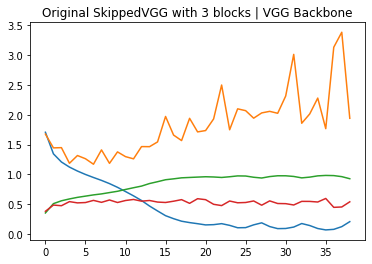

In [12]:
plt.title('Original SkippedVGG with 3 blocks | VGG Backbone')
plt.plot(hist), best_acc

Original SkippedVGG perhaps not have a good adaption to FER dataset. I'm thinking of increasing to 4 block and add residual connection to each SVblock

### Add residual in SV block

In [20]:
model = model.to(device)

model_path = '/tf/data/Quan/fer2013/backtobasics/skippedvgg_3blocks_residual.pt'
best_acc = 0.0
hist = []

for epoch in range(60):  # loop over the dataset multiple times
    
    print('Epoch: ', epoch + 1)
    running_loss = 0.0
    running_acc = 0.0

    # TRAIN
    model.train()
    for i, data in enumerate(train_loader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        acc = float((torch.argmax(outputs, dim=1) == labels).float().sum()/labels.size(0))
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        running_acc += acc
        print('\t - Step %d: loss: %.3f acc: %.3f' % (i+1, loss.item(), acc))

    print('- Avg.loss: %.3f  | Avg.acc: %.3f' % (running_loss / (i+1), running_acc / (i+1)))
    avgloss = running_loss / (i+1)
    avgacc = running_acc / (i+1)

    # EVALUATE
    model.eval()
    running_valloss = 0.0
    running_valacc = 0.0
    for i,data in enumerate(val_loader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        acc = float((torch.argmax(outputs, dim=1) == labels).float().sum()/labels.size(0))
        loss = criterion(outputs, labels)

        running_valloss += loss.item()
        running_valacc += acc

    print('- Avg. val_loss: %.3f  | Avg. val_acc: %.3f' % (running_valloss / (i+1), running_valacc / (i+1)))

    avgvalloss = running_valloss / (i+1)
    avgvalcc = running_valacc / (i+1)

    hist.append([avgloss, avgvalloss, avgacc, avgvalcc])
    
    if best_acc < (running_valacc / (i+1)):
        best_acc = (running_valacc / (i+1))
        torch.save(model, model_path)
        print('* Update optimal model')

print('Finished Training')

Epoch:  1
	 - Step 1: loss: 2.445 acc: 0.133
	 - Step 2: loss: 1.989 acc: 0.195
	 - Step 3: loss: 2.115 acc: 0.172
	 - Step 4: loss: 1.997 acc: 0.258
	 - Step 5: loss: 2.064 acc: 0.195
	 - Step 6: loss: 2.043 acc: 0.234
	 - Step 7: loss: 1.976 acc: 0.258
	 - Step 8: loss: 1.917 acc: 0.250
	 - Step 9: loss: 2.042 acc: 0.227
	 - Step 10: loss: 2.042 acc: 0.227
	 - Step 11: loss: 1.973 acc: 0.219
	 - Step 12: loss: 1.890 acc: 0.242
	 - Step 13: loss: 1.887 acc: 0.281
	 - Step 14: loss: 1.928 acc: 0.242
	 - Step 15: loss: 1.913 acc: 0.266
	 - Step 16: loss: 1.976 acc: 0.172
	 - Step 17: loss: 1.941 acc: 0.203
	 - Step 18: loss: 1.901 acc: 0.242
	 - Step 19: loss: 1.928 acc: 0.234
	 - Step 20: loss: 1.919 acc: 0.258
	 - Step 21: loss: 1.907 acc: 0.234
	 - Step 22: loss: 1.927 acc: 0.281
	 - Step 23: loss: 1.909 acc: 0.219
	 - Step 24: loss: 1.909 acc: 0.281
	 - Step 25: loss: 1.915 acc: 0.219
	 - Step 26: loss: 1.899 acc: 0.242
	 - Step 27: loss: 1.887 acc: 0.250
	 - Step 28: loss: 1.905 ac

- Avg. val_loss: 2.438  | Avg. val_acc: 0.257
* Update optimal model
Epoch:  2
	 - Step 1: loss: 1.306 acc: 0.500
	 - Step 2: loss: 1.422 acc: 0.492
	 - Step 3: loss: 1.465 acc: 0.469
	 - Step 4: loss: 1.403 acc: 0.469
	 - Step 5: loss: 1.461 acc: 0.414
	 - Step 6: loss: 1.390 acc: 0.508
	 - Step 7: loss: 1.419 acc: 0.492
	 - Step 8: loss: 1.388 acc: 0.477
	 - Step 9: loss: 1.427 acc: 0.477
	 - Step 10: loss: 1.385 acc: 0.484
	 - Step 11: loss: 1.555 acc: 0.383
	 - Step 12: loss: 1.382 acc: 0.492
	 - Step 13: loss: 1.379 acc: 0.508
	 - Step 14: loss: 1.306 acc: 0.578
	 - Step 15: loss: 1.391 acc: 0.531
	 - Step 16: loss: 1.389 acc: 0.508
	 - Step 17: loss: 1.374 acc: 0.445
	 - Step 18: loss: 1.469 acc: 0.430
	 - Step 19: loss: 1.337 acc: 0.516
	 - Step 20: loss: 1.453 acc: 0.438
	 - Step 21: loss: 1.392 acc: 0.523
	 - Step 22: loss: 1.449 acc: 0.539
	 - Step 23: loss: 1.438 acc: 0.469
	 - Step 24: loss: 1.364 acc: 0.508
	 - Step 25: loss: 1.416 acc: 0.516
	 - Step 26: loss: 1.425 acc: 

	 - Step 225: loss: 1.327 acc: 0.514
- Avg.loss: 1.335  | Avg.acc: 0.518
- Avg. val_loss: 1.605  | Avg. val_acc: 0.360
* Update optimal model
Epoch:  3
	 - Step 1: loss: 1.263 acc: 0.547
	 - Step 2: loss: 1.189 acc: 0.539
	 - Step 3: loss: 1.207 acc: 0.531
	 - Step 4: loss: 1.229 acc: 0.570
	 - Step 5: loss: 1.245 acc: 0.562
	 - Step 6: loss: 1.155 acc: 0.617
	 - Step 7: loss: 1.402 acc: 0.453
	 - Step 8: loss: 1.293 acc: 0.508
	 - Step 9: loss: 1.224 acc: 0.547
	 - Step 10: loss: 1.233 acc: 0.562
	 - Step 11: loss: 1.325 acc: 0.523
	 - Step 12: loss: 1.202 acc: 0.617
	 - Step 13: loss: 1.271 acc: 0.523
	 - Step 14: loss: 1.216 acc: 0.555
	 - Step 15: loss: 1.295 acc: 0.594
	 - Step 16: loss: 1.192 acc: 0.562
	 - Step 17: loss: 1.273 acc: 0.508
	 - Step 18: loss: 1.239 acc: 0.602
	 - Step 19: loss: 1.241 acc: 0.586
	 - Step 20: loss: 1.345 acc: 0.508
	 - Step 21: loss: 1.302 acc: 0.578
	 - Step 22: loss: 1.256 acc: 0.578
	 - Step 23: loss: 1.239 acc: 0.555
	 - Step 24: loss: 1.263 acc:

	 - Step 225: loss: 1.257 acc: 0.568
- Avg.loss: 1.206  | Avg.acc: 0.566
- Avg. val_loss: 1.487  | Avg. val_acc: 0.417
* Update optimal model
Epoch:  4
	 - Step 1: loss: 1.096 acc: 0.625
	 - Step 2: loss: 1.159 acc: 0.602
	 - Step 3: loss: 1.255 acc: 0.539
	 - Step 4: loss: 1.335 acc: 0.539
	 - Step 5: loss: 0.979 acc: 0.672
	 - Step 6: loss: 1.132 acc: 0.562
	 - Step 7: loss: 1.053 acc: 0.609
	 - Step 8: loss: 1.215 acc: 0.555
	 - Step 9: loss: 1.127 acc: 0.602
	 - Step 10: loss: 1.007 acc: 0.695
	 - Step 11: loss: 1.107 acc: 0.625
	 - Step 12: loss: 1.000 acc: 0.656
	 - Step 13: loss: 1.034 acc: 0.641
	 - Step 14: loss: 1.278 acc: 0.523
	 - Step 15: loss: 1.028 acc: 0.586
	 - Step 16: loss: 1.018 acc: 0.664
	 - Step 17: loss: 1.124 acc: 0.602
	 - Step 18: loss: 1.117 acc: 0.609
	 - Step 19: loss: 1.125 acc: 0.641
	 - Step 20: loss: 1.044 acc: 0.633
	 - Step 21: loss: 1.043 acc: 0.641
	 - Step 22: loss: 1.112 acc: 0.570
	 - Step 23: loss: 1.242 acc: 0.547
	 - Step 24: loss: 1.176 acc:

	 - Step 225: loss: 1.253 acc: 0.459
- Avg.loss: 1.123  | Avg.acc: 0.596
- Avg. val_loss: 1.532  | Avg. val_acc: 0.426
* Update optimal model
Epoch:  5
	 - Step 1: loss: 1.051 acc: 0.609
	 - Step 2: loss: 1.024 acc: 0.656
	 - Step 3: loss: 1.087 acc: 0.617
	 - Step 4: loss: 1.090 acc: 0.617
	 - Step 5: loss: 1.123 acc: 0.641
	 - Step 6: loss: 0.955 acc: 0.664
	 - Step 7: loss: 1.096 acc: 0.586
	 - Step 8: loss: 1.117 acc: 0.617
	 - Step 9: loss: 1.146 acc: 0.633
	 - Step 10: loss: 1.038 acc: 0.656
	 - Step 11: loss: 1.074 acc: 0.609
	 - Step 12: loss: 1.055 acc: 0.609
	 - Step 13: loss: 0.996 acc: 0.633
	 - Step 14: loss: 0.961 acc: 0.641
	 - Step 15: loss: 1.069 acc: 0.633
	 - Step 16: loss: 1.126 acc: 0.555
	 - Step 17: loss: 1.060 acc: 0.609
	 - Step 18: loss: 1.011 acc: 0.648
	 - Step 19: loss: 1.126 acc: 0.602
	 - Step 20: loss: 1.031 acc: 0.641
	 - Step 21: loss: 1.074 acc: 0.656
	 - Step 22: loss: 1.061 acc: 0.641
	 - Step 23: loss: 0.993 acc: 0.656
	 - Step 24: loss: 0.982 acc:

	 - Step 225: loss: 0.944 acc: 0.703
- Avg.loss: 1.058  | Avg.acc: 0.618
- Avg. val_loss: 1.656  | Avg. val_acc: 0.416
Epoch:  6
	 - Step 1: loss: 0.902 acc: 0.656
	 - Step 2: loss: 0.943 acc: 0.688
	 - Step 3: loss: 0.914 acc: 0.727
	 - Step 4: loss: 1.157 acc: 0.516
	 - Step 5: loss: 1.023 acc: 0.609
	 - Step 6: loss: 0.841 acc: 0.727
	 - Step 7: loss: 0.990 acc: 0.641
	 - Step 8: loss: 1.082 acc: 0.617
	 - Step 9: loss: 0.945 acc: 0.656
	 - Step 10: loss: 0.998 acc: 0.609
	 - Step 11: loss: 0.890 acc: 0.711
	 - Step 12: loss: 0.940 acc: 0.680
	 - Step 13: loss: 1.001 acc: 0.625
	 - Step 14: loss: 0.963 acc: 0.648
	 - Step 15: loss: 0.930 acc: 0.703
	 - Step 16: loss: 1.064 acc: 0.617
	 - Step 17: loss: 1.030 acc: 0.633
	 - Step 18: loss: 0.891 acc: 0.680
	 - Step 19: loss: 0.974 acc: 0.633
	 - Step 20: loss: 0.968 acc: 0.633
	 - Step 21: loss: 0.965 acc: 0.672
	 - Step 22: loss: 1.078 acc: 0.648
	 - Step 23: loss: 0.947 acc: 0.672
	 - Step 24: loss: 0.890 acc: 0.719
	 - Step 25: los

	 - Step 225: loss: 1.120 acc: 0.486
- Avg.loss: 1.002  | Avg.acc: 0.636
- Avg. val_loss: 1.555  | Avg. val_acc: 0.381
Epoch:  7
	 - Step 1: loss: 0.883 acc: 0.703
	 - Step 2: loss: 0.988 acc: 0.648
	 - Step 3: loss: 0.801 acc: 0.711
	 - Step 4: loss: 0.879 acc: 0.727
	 - Step 5: loss: 0.961 acc: 0.625
	 - Step 6: loss: 1.017 acc: 0.648
	 - Step 7: loss: 0.984 acc: 0.664
	 - Step 8: loss: 0.949 acc: 0.656
	 - Step 9: loss: 0.924 acc: 0.695
	 - Step 10: loss: 0.897 acc: 0.688
	 - Step 11: loss: 1.057 acc: 0.547
	 - Step 12: loss: 0.897 acc: 0.680
	 - Step 13: loss: 0.770 acc: 0.742
	 - Step 14: loss: 0.890 acc: 0.742
	 - Step 15: loss: 0.891 acc: 0.695
	 - Step 16: loss: 0.828 acc: 0.688
	 - Step 17: loss: 0.845 acc: 0.711
	 - Step 18: loss: 0.869 acc: 0.719
	 - Step 19: loss: 0.951 acc: 0.672
	 - Step 20: loss: 0.844 acc: 0.727
	 - Step 21: loss: 0.883 acc: 0.703
	 - Step 22: loss: 0.827 acc: 0.727
	 - Step 23: loss: 0.932 acc: 0.688
	 - Step 24: loss: 0.955 acc: 0.672
	 - Step 25: los

	 - Step 225: loss: 0.984 acc: 0.649
- Avg.loss: 0.946  | Avg.acc: 0.661
- Avg. val_loss: 1.403  | Avg. val_acc: 0.524
* Update optimal model
Epoch:  8
	 - Step 1: loss: 0.848 acc: 0.711
	 - Step 2: loss: 0.821 acc: 0.695
	 - Step 3: loss: 0.782 acc: 0.727
	 - Step 4: loss: 0.768 acc: 0.773
	 - Step 5: loss: 0.731 acc: 0.742
	 - Step 6: loss: 0.859 acc: 0.711
	 - Step 7: loss: 0.740 acc: 0.766
	 - Step 8: loss: 0.873 acc: 0.672
	 - Step 9: loss: 0.852 acc: 0.711
	 - Step 10: loss: 0.975 acc: 0.648
	 - Step 11: loss: 0.823 acc: 0.727
	 - Step 12: loss: 0.795 acc: 0.711
	 - Step 13: loss: 0.817 acc: 0.711
	 - Step 14: loss: 0.801 acc: 0.664
	 - Step 15: loss: 0.834 acc: 0.703
	 - Step 16: loss: 0.949 acc: 0.586
	 - Step 17: loss: 0.869 acc: 0.656
	 - Step 18: loss: 0.865 acc: 0.680
	 - Step 19: loss: 0.767 acc: 0.758
	 - Step 20: loss: 0.769 acc: 0.727
	 - Step 21: loss: 0.961 acc: 0.648
	 - Step 22: loss: 0.751 acc: 0.719
	 - Step 23: loss: 0.814 acc: 0.688
	 - Step 24: loss: 0.766 acc:

	 - Step 225: loss: 0.905 acc: 0.649
- Avg.loss: 0.881  | Avg.acc: 0.685
- Avg. val_loss: 1.786  | Avg. val_acc: 0.430
Epoch:  9
	 - Step 1: loss: 0.720 acc: 0.711
	 - Step 2: loss: 0.871 acc: 0.672
	 - Step 3: loss: 0.681 acc: 0.812
	 - Step 4: loss: 0.818 acc: 0.711
	 - Step 5: loss: 0.922 acc: 0.672
	 - Step 6: loss: 0.930 acc: 0.648
	 - Step 7: loss: 0.888 acc: 0.688
	 - Step 8: loss: 0.788 acc: 0.695
	 - Step 9: loss: 0.775 acc: 0.742
	 - Step 10: loss: 0.787 acc: 0.727
	 - Step 11: loss: 0.779 acc: 0.703
	 - Step 12: loss: 0.778 acc: 0.727
	 - Step 13: loss: 0.827 acc: 0.711
	 - Step 14: loss: 0.781 acc: 0.750
	 - Step 15: loss: 0.715 acc: 0.766
	 - Step 16: loss: 0.782 acc: 0.703
	 - Step 17: loss: 0.763 acc: 0.680
	 - Step 18: loss: 0.719 acc: 0.758
	 - Step 19: loss: 0.814 acc: 0.734
	 - Step 20: loss: 0.845 acc: 0.664
	 - Step 21: loss: 0.759 acc: 0.711
	 - Step 22: loss: 0.933 acc: 0.641
	 - Step 23: loss: 0.670 acc: 0.797
	 - Step 24: loss: 0.790 acc: 0.750
	 - Step 25: los

	 - Step 225: loss: 0.705 acc: 0.757
- Avg.loss: 0.823  | Avg.acc: 0.706
- Avg. val_loss: 1.645  | Avg. val_acc: 0.507
Epoch:  10
	 - Step 1: loss: 0.732 acc: 0.750
	 - Step 2: loss: 0.633 acc: 0.789
	 - Step 3: loss: 0.658 acc: 0.766
	 - Step 4: loss: 0.727 acc: 0.766
	 - Step 5: loss: 0.670 acc: 0.820
	 - Step 6: loss: 0.693 acc: 0.773
	 - Step 7: loss: 0.615 acc: 0.805
	 - Step 8: loss: 0.593 acc: 0.828
	 - Step 9: loss: 0.815 acc: 0.727
	 - Step 10: loss: 0.761 acc: 0.742
	 - Step 11: loss: 0.640 acc: 0.812
	 - Step 12: loss: 0.717 acc: 0.750
	 - Step 13: loss: 0.695 acc: 0.797
	 - Step 14: loss: 0.608 acc: 0.812
	 - Step 15: loss: 0.705 acc: 0.758
	 - Step 16: loss: 0.570 acc: 0.828
	 - Step 17: loss: 0.594 acc: 0.844
	 - Step 18: loss: 0.633 acc: 0.805
	 - Step 19: loss: 0.651 acc: 0.758
	 - Step 20: loss: 0.768 acc: 0.758
	 - Step 21: loss: 0.677 acc: 0.750
	 - Step 22: loss: 0.737 acc: 0.766
	 - Step 23: loss: 0.758 acc: 0.734
	 - Step 24: loss: 0.758 acc: 0.719
	 - Step 25: lo

	 - Step 225: loss: 0.774 acc: 0.703
- Avg.loss: 0.752  | Avg.acc: 0.737
- Avg. val_loss: 1.429  | Avg. val_acc: 0.522
Epoch:  11
	 - Step 1: loss: 0.633 acc: 0.812
	 - Step 2: loss: 0.533 acc: 0.875
	 - Step 3: loss: 0.568 acc: 0.812
	 - Step 4: loss: 0.628 acc: 0.766
	 - Step 5: loss: 0.625 acc: 0.789
	 - Step 6: loss: 0.567 acc: 0.805
	 - Step 7: loss: 0.627 acc: 0.781
	 - Step 8: loss: 0.613 acc: 0.797
	 - Step 9: loss: 0.565 acc: 0.812
	 - Step 10: loss: 0.609 acc: 0.797
	 - Step 11: loss: 0.655 acc: 0.781
	 - Step 12: loss: 0.728 acc: 0.750
	 - Step 13: loss: 0.635 acc: 0.781
	 - Step 14: loss: 0.588 acc: 0.812
	 - Step 15: loss: 0.507 acc: 0.859
	 - Step 16: loss: 0.664 acc: 0.750
	 - Step 17: loss: 0.640 acc: 0.789
	 - Step 18: loss: 0.618 acc: 0.828
	 - Step 19: loss: 0.565 acc: 0.812
	 - Step 20: loss: 0.593 acc: 0.773
	 - Step 21: loss: 0.538 acc: 0.820
	 - Step 22: loss: 0.604 acc: 0.820
	 - Step 23: loss: 0.618 acc: 0.805
	 - Step 24: loss: 0.626 acc: 0.820
	 - Step 25: lo

	 - Step 225: loss: 0.742 acc: 0.811
- Avg.loss: 0.664  | Avg.acc: 0.772
- Avg. val_loss: 2.535  | Avg. val_acc: 0.399
Epoch:  12
	 - Step 1: loss: 0.528 acc: 0.828
	 - Step 2: loss: 0.507 acc: 0.836
	 - Step 3: loss: 0.655 acc: 0.766
	 - Step 4: loss: 0.581 acc: 0.805
	 - Step 5: loss: 0.391 acc: 0.906
	 - Step 6: loss: 0.506 acc: 0.875
	 - Step 7: loss: 0.457 acc: 0.883
	 - Step 8: loss: 0.547 acc: 0.852
	 - Step 9: loss: 0.550 acc: 0.844
	 - Step 10: loss: 0.542 acc: 0.820
	 - Step 11: loss: 0.560 acc: 0.812
	 - Step 12: loss: 0.469 acc: 0.867
	 - Step 13: loss: 0.506 acc: 0.836
	 - Step 14: loss: 0.528 acc: 0.805
	 - Step 15: loss: 0.525 acc: 0.844
	 - Step 16: loss: 0.607 acc: 0.789
	 - Step 17: loss: 0.596 acc: 0.820
	 - Step 18: loss: 0.427 acc: 0.891
	 - Step 19: loss: 0.562 acc: 0.836
	 - Step 20: loss: 0.531 acc: 0.836
	 - Step 21: loss: 0.571 acc: 0.781
	 - Step 22: loss: 0.515 acc: 0.836
	 - Step 23: loss: 0.461 acc: 0.883
	 - Step 24: loss: 0.599 acc: 0.758
	 - Step 25: lo

	 - Step 225: loss: 0.539 acc: 0.838
- Avg.loss: 0.579  | Avg.acc: 0.805
- Avg. val_loss: 2.790  | Avg. val_acc: 0.364
Epoch:  13
	 - Step 1: loss: 0.390 acc: 0.891
	 - Step 2: loss: 0.497 acc: 0.828
	 - Step 3: loss: 0.410 acc: 0.867
	 - Step 4: loss: 0.565 acc: 0.844
	 - Step 5: loss: 0.535 acc: 0.859
	 - Step 6: loss: 0.405 acc: 0.875
	 - Step 7: loss: 0.417 acc: 0.883
	 - Step 8: loss: 0.475 acc: 0.859
	 - Step 9: loss: 0.396 acc: 0.883
	 - Step 10: loss: 0.454 acc: 0.852
	 - Step 11: loss: 0.469 acc: 0.852
	 - Step 12: loss: 0.433 acc: 0.875
	 - Step 13: loss: 0.489 acc: 0.852
	 - Step 14: loss: 0.519 acc: 0.836
	 - Step 15: loss: 0.428 acc: 0.867
	 - Step 16: loss: 0.486 acc: 0.828
	 - Step 17: loss: 0.401 acc: 0.883
	 - Step 18: loss: 0.353 acc: 0.922
	 - Step 19: loss: 0.403 acc: 0.891
	 - Step 20: loss: 0.439 acc: 0.867
	 - Step 21: loss: 0.360 acc: 0.898
	 - Step 22: loss: 0.456 acc: 0.859
	 - Step 23: loss: 0.367 acc: 0.875
	 - Step 24: loss: 0.366 acc: 0.891
	 - Step 25: lo

	 - Step 225: loss: 0.513 acc: 0.838
- Avg.loss: 0.469  | Avg.acc: 0.853
- Avg. val_loss: 2.504  | Avg. val_acc: 0.418
Epoch:  14
	 - Step 1: loss: 0.373 acc: 0.891
	 - Step 2: loss: 0.361 acc: 0.898
	 - Step 3: loss: 0.357 acc: 0.914
	 - Step 4: loss: 0.408 acc: 0.875
	 - Step 5: loss: 0.334 acc: 0.930
	 - Step 6: loss: 0.330 acc: 0.914
	 - Step 7: loss: 0.408 acc: 0.875
	 - Step 8: loss: 0.325 acc: 0.930
	 - Step 9: loss: 0.325 acc: 0.883
	 - Step 10: loss: 0.447 acc: 0.859
	 - Step 11: loss: 0.363 acc: 0.891
	 - Step 12: loss: 0.384 acc: 0.914
	 - Step 13: loss: 0.368 acc: 0.891
	 - Step 14: loss: 0.365 acc: 0.945
	 - Step 15: loss: 0.465 acc: 0.836
	 - Step 16: loss: 0.374 acc: 0.898
	 - Step 17: loss: 0.370 acc: 0.852
	 - Step 18: loss: 0.337 acc: 0.875
	 - Step 19: loss: 0.358 acc: 0.898
	 - Step 20: loss: 0.319 acc: 0.922
	 - Step 21: loss: 0.290 acc: 0.930
	 - Step 22: loss: 0.383 acc: 0.891
	 - Step 23: loss: 0.332 acc: 0.914
	 - Step 24: loss: 0.331 acc: 0.945
	 - Step 25: lo

	 - Step 225: loss: 0.351 acc: 0.919
- Avg.loss: 0.371  | Avg.acc: 0.893
- Avg. val_loss: 1.628  | Avg. val_acc: 0.515
Epoch:  15
	 - Step 1: loss: 0.279 acc: 0.922
	 - Step 2: loss: 0.294 acc: 0.906
	 - Step 3: loss: 0.421 acc: 0.875
	 - Step 4: loss: 0.291 acc: 0.930
	 - Step 5: loss: 0.328 acc: 0.883
	 - Step 6: loss: 0.304 acc: 0.898
	 - Step 7: loss: 0.314 acc: 0.891
	 - Step 8: loss: 0.242 acc: 0.977
	 - Step 9: loss: 0.254 acc: 0.938
	 - Step 10: loss: 0.293 acc: 0.914
	 - Step 11: loss: 0.364 acc: 0.883
	 - Step 12: loss: 0.275 acc: 0.938
	 - Step 13: loss: 0.293 acc: 0.922
	 - Step 14: loss: 0.272 acc: 0.953
	 - Step 15: loss: 0.295 acc: 0.906
	 - Step 16: loss: 0.257 acc: 0.906
	 - Step 17: loss: 0.263 acc: 0.945
	 - Step 18: loss: 0.244 acc: 0.953
	 - Step 19: loss: 0.323 acc: 0.914
	 - Step 20: loss: 0.300 acc: 0.938
	 - Step 21: loss: 0.314 acc: 0.906
	 - Step 22: loss: 0.311 acc: 0.898
	 - Step 23: loss: 0.288 acc: 0.945
	 - Step 24: loss: 0.195 acc: 0.969
	 - Step 25: lo

	 - Step 225: loss: 0.466 acc: 0.811
- Avg.loss: 0.294  | Avg.acc: 0.921
- Avg. val_loss: 2.427  | Avg. val_acc: 0.397
Epoch:  16
	 - Step 1: loss: 0.205 acc: 0.961
	 - Step 2: loss: 0.248 acc: 0.938
	 - Step 3: loss: 0.246 acc: 0.953
	 - Step 4: loss: 0.260 acc: 0.945
	 - Step 5: loss: 0.318 acc: 0.914
	 - Step 6: loss: 0.351 acc: 0.852
	 - Step 7: loss: 0.238 acc: 0.938
	 - Step 8: loss: 0.288 acc: 0.953
	 - Step 9: loss: 0.354 acc: 0.891
	 - Step 10: loss: 0.215 acc: 0.953
	 - Step 11: loss: 0.333 acc: 0.875
	 - Step 12: loss: 0.250 acc: 0.930
	 - Step 13: loss: 0.279 acc: 0.914
	 - Step 14: loss: 0.254 acc: 0.938
	 - Step 15: loss: 0.345 acc: 0.891
	 - Step 16: loss: 0.363 acc: 0.891
	 - Step 17: loss: 0.270 acc: 0.938
	 - Step 18: loss: 0.403 acc: 0.883
	 - Step 19: loss: 0.239 acc: 0.930
	 - Step 20: loss: 0.253 acc: 0.930
	 - Step 21: loss: 0.249 acc: 0.938
	 - Step 22: loss: 0.265 acc: 0.922
	 - Step 23: loss: 0.187 acc: 0.953
	 - Step 24: loss: 0.214 acc: 0.953
	 - Step 25: lo

	 - Step 225: loss: 0.349 acc: 0.892
- Avg.loss: 0.257  | Avg.acc: 0.934
- Avg. val_loss: 2.447  | Avg. val_acc: 0.442
Epoch:  17
	 - Step 1: loss: 0.159 acc: 0.992
	 - Step 2: loss: 0.209 acc: 0.977
	 - Step 3: loss: 0.225 acc: 0.945
	 - Step 4: loss: 0.186 acc: 0.969
	 - Step 5: loss: 0.187 acc: 0.961
	 - Step 6: loss: 0.284 acc: 0.961
	 - Step 7: loss: 0.156 acc: 1.000
	 - Step 8: loss: 0.173 acc: 0.969
	 - Step 9: loss: 0.226 acc: 0.953
	 - Step 10: loss: 0.178 acc: 0.984
	 - Step 11: loss: 0.223 acc: 0.953
	 - Step 12: loss: 0.209 acc: 0.945
	 - Step 13: loss: 0.223 acc: 0.938
	 - Step 14: loss: 0.263 acc: 0.930
	 - Step 15: loss: 0.287 acc: 0.930
	 - Step 16: loss: 0.265 acc: 0.938
	 - Step 17: loss: 0.267 acc: 0.945
	 - Step 18: loss: 0.197 acc: 0.953
	 - Step 19: loss: 0.204 acc: 0.945
	 - Step 20: loss: 0.201 acc: 0.961
	 - Step 21: loss: 0.204 acc: 0.938
	 - Step 22: loss: 0.218 acc: 0.938
	 - Step 23: loss: 0.259 acc: 0.938
	 - Step 24: loss: 0.163 acc: 0.969
	 - Step 25: lo

	 - Step 225: loss: 0.385 acc: 0.811
- Avg.loss: 0.198  | Avg.acc: 0.955
- Avg. val_loss: 3.364  | Avg. val_acc: 0.371
Epoch:  18
	 - Step 1: loss: 0.154 acc: 0.969
	 - Step 2: loss: 0.267 acc: 0.945
	 - Step 3: loss: 0.278 acc: 0.945
	 - Step 4: loss: 0.125 acc: 0.992
	 - Step 5: loss: 0.138 acc: 0.992
	 - Step 6: loss: 0.208 acc: 0.938
	 - Step 7: loss: 0.193 acc: 0.953
	 - Step 8: loss: 0.168 acc: 0.977
	 - Step 9: loss: 0.200 acc: 0.930
	 - Step 10: loss: 0.184 acc: 0.969
	 - Step 11: loss: 0.131 acc: 0.992
	 - Step 12: loss: 0.169 acc: 0.969
	 - Step 13: loss: 0.149 acc: 0.984
	 - Step 14: loss: 0.160 acc: 0.969
	 - Step 15: loss: 0.172 acc: 0.969
	 - Step 16: loss: 0.245 acc: 0.914
	 - Step 17: loss: 0.177 acc: 0.969
	 - Step 18: loss: 0.192 acc: 0.953
	 - Step 19: loss: 0.172 acc: 0.969
	 - Step 20: loss: 0.186 acc: 0.945
	 - Step 21: loss: 0.266 acc: 0.945
	 - Step 22: loss: 0.198 acc: 0.961
	 - Step 23: loss: 0.126 acc: 0.984
	 - Step 24: loss: 0.201 acc: 0.961
	 - Step 25: lo

	 - Step 225: loss: 0.191 acc: 0.973
- Avg.loss: 0.186  | Avg.acc: 0.959
- Avg. val_loss: 7.775  | Avg. val_acc: 0.154
Epoch:  19
	 - Step 1: loss: 0.173 acc: 0.977
	 - Step 2: loss: 0.137 acc: 0.961
	 - Step 3: loss: 0.147 acc: 0.984
	 - Step 4: loss: 0.145 acc: 0.977
	 - Step 5: loss: 0.193 acc: 0.961
	 - Step 6: loss: 0.192 acc: 0.969
	 - Step 7: loss: 0.247 acc: 0.938
	 - Step 8: loss: 0.201 acc: 0.945
	 - Step 9: loss: 0.145 acc: 0.984
	 - Step 10: loss: 0.182 acc: 0.953
	 - Step 11: loss: 0.168 acc: 0.984
	 - Step 12: loss: 0.135 acc: 0.961
	 - Step 13: loss: 0.174 acc: 0.969
	 - Step 14: loss: 0.156 acc: 0.961
	 - Step 15: loss: 0.178 acc: 0.977
	 - Step 16: loss: 0.217 acc: 0.984
	 - Step 17: loss: 0.147 acc: 0.977
	 - Step 18: loss: 0.186 acc: 0.961
	 - Step 19: loss: 0.151 acc: 0.977
	 - Step 20: loss: 0.150 acc: 0.969
	 - Step 21: loss: 0.206 acc: 0.969
	 - Step 22: loss: 0.149 acc: 0.969
	 - Step 23: loss: 0.170 acc: 0.969
	 - Step 24: loss: 0.153 acc: 0.961
	 - Step 25: lo

	 - Step 225: loss: 0.208 acc: 0.919
- Avg.loss: 0.179  | Avg.acc: 0.960
- Avg. val_loss: 5.746  | Avg. val_acc: 0.215
Epoch:  20
	 - Step 1: loss: 0.103 acc: 0.984
	 - Step 2: loss: 0.244 acc: 0.906
	 - Step 3: loss: 0.135 acc: 0.953
	 - Step 4: loss: 0.165 acc: 0.969
	 - Step 5: loss: 0.130 acc: 0.977
	 - Step 6: loss: 0.252 acc: 0.930
	 - Step 7: loss: 0.142 acc: 0.984
	 - Step 8: loss: 0.255 acc: 0.953
	 - Step 9: loss: 0.122 acc: 0.969
	 - Step 10: loss: 0.232 acc: 0.898
	 - Step 11: loss: 0.216 acc: 0.922
	 - Step 12: loss: 0.247 acc: 0.922
	 - Step 13: loss: 0.147 acc: 0.984
	 - Step 14: loss: 0.192 acc: 0.953
	 - Step 15: loss: 0.150 acc: 0.961
	 - Step 16: loss: 0.149 acc: 0.977
	 - Step 17: loss: 0.141 acc: 0.969
	 - Step 18: loss: 0.100 acc: 0.992
	 - Step 19: loss: 0.191 acc: 0.930
	 - Step 20: loss: 0.197 acc: 0.922
	 - Step 21: loss: 0.126 acc: 0.984
	 - Step 22: loss: 0.259 acc: 0.945
	 - Step 23: loss: 0.134 acc: 0.953
	 - Step 24: loss: 0.164 acc: 0.961
	 - Step 25: lo

	 - Step 225: loss: 0.457 acc: 0.865
- Avg.loss: 0.173  | Avg.acc: 0.960
- Avg. val_loss: 3.442  | Avg. val_acc: 0.364
Epoch:  21
	 - Step 1: loss: 0.134 acc: 0.961
	 - Step 2: loss: 0.126 acc: 0.984
	 - Step 3: loss: 0.127 acc: 0.984
	 - Step 4: loss: 0.196 acc: 0.953
	 - Step 5: loss: 0.152 acc: 0.984
	 - Step 6: loss: 0.246 acc: 0.938
	 - Step 7: loss: 0.191 acc: 0.945
	 - Step 8: loss: 0.251 acc: 0.930
	 - Step 9: loss: 0.158 acc: 0.961
	 - Step 10: loss: 0.141 acc: 0.977
	 - Step 11: loss: 0.153 acc: 0.961
	 - Step 12: loss: 0.166 acc: 0.945
	 - Step 13: loss: 0.163 acc: 0.945
	 - Step 14: loss: 0.179 acc: 0.953
	 - Step 15: loss: 0.158 acc: 0.969
	 - Step 16: loss: 0.146 acc: 0.961
	 - Step 17: loss: 0.320 acc: 0.945
	 - Step 18: loss: 0.211 acc: 0.969
	 - Step 19: loss: 0.165 acc: 0.969
	 - Step 20: loss: 0.169 acc: 0.969
	 - Step 21: loss: 0.171 acc: 0.961
	 - Step 22: loss: 0.238 acc: 0.898
	 - Step 23: loss: 0.157 acc: 0.977
	 - Step 24: loss: 0.168 acc: 0.945
	 - Step 25: lo

	 - Step 225: loss: 0.419 acc: 0.865
- Avg.loss: 0.173  | Avg.acc: 0.958
- Avg. val_loss: 4.253  | Avg. val_acc: 0.439
Epoch:  22
	 - Step 1: loss: 0.107 acc: 0.984
	 - Step 2: loss: 0.144 acc: 0.961
	 - Step 3: loss: 0.206 acc: 0.953
	 - Step 4: loss: 0.217 acc: 0.938
	 - Step 5: loss: 0.138 acc: 0.977
	 - Step 6: loss: 0.139 acc: 0.977
	 - Step 7: loss: 0.229 acc: 0.906
	 - Step 8: loss: 0.129 acc: 0.969
	 - Step 9: loss: 0.164 acc: 0.961
	 - Step 10: loss: 0.132 acc: 0.961
	 - Step 11: loss: 0.138 acc: 0.969
	 - Step 12: loss: 0.172 acc: 0.961
	 - Step 13: loss: 0.209 acc: 0.938
	 - Step 14: loss: 0.301 acc: 0.922
	 - Step 15: loss: 0.146 acc: 0.953
	 - Step 16: loss: 0.211 acc: 0.945
	 - Step 17: loss: 0.196 acc: 0.945
	 - Step 18: loss: 0.150 acc: 0.969
	 - Step 19: loss: 0.255 acc: 0.945
	 - Step 20: loss: 0.140 acc: 0.961
	 - Step 21: loss: 0.204 acc: 0.945
	 - Step 22: loss: 0.142 acc: 0.969
	 - Step 23: loss: 0.167 acc: 0.945
	 - Step 24: loss: 0.166 acc: 0.953
	 - Step 25: lo

	 - Step 225: loss: 0.336 acc: 0.919
- Avg.loss: 0.174  | Avg.acc: 0.956
- Avg. val_loss: 2.689  | Avg. val_acc: 0.476
Epoch:  23
	 - Step 1: loss: 0.115 acc: 0.969
	 - Step 2: loss: 0.117 acc: 0.969
	 - Step 3: loss: 0.156 acc: 0.969
	 - Step 4: loss: 0.218 acc: 0.938
	 - Step 5: loss: 0.155 acc: 0.945
	 - Step 6: loss: 0.106 acc: 0.992
	 - Step 7: loss: 0.199 acc: 0.938
	 - Step 8: loss: 0.163 acc: 0.961
	 - Step 9: loss: 0.192 acc: 0.930
	 - Step 10: loss: 0.207 acc: 0.945
	 - Step 11: loss: 0.095 acc: 0.984
	 - Step 12: loss: 0.238 acc: 0.930
	 - Step 13: loss: 0.117 acc: 0.992
	 - Step 14: loss: 0.167 acc: 0.953
	 - Step 15: loss: 0.120 acc: 0.977
	 - Step 16: loss: 0.153 acc: 0.953
	 - Step 17: loss: 0.156 acc: 0.945
	 - Step 18: loss: 0.152 acc: 0.984
	 - Step 19: loss: 0.160 acc: 0.945
	 - Step 20: loss: 0.125 acc: 0.977
	 - Step 21: loss: 0.081 acc: 0.992
	 - Step 22: loss: 0.222 acc: 0.922
	 - Step 23: loss: 0.143 acc: 0.961
	 - Step 24: loss: 0.198 acc: 0.938
	 - Step 25: lo

	 - Step 225: loss: 0.202 acc: 0.973
- Avg.loss: 0.159  | Avg.acc: 0.961
- Avg. val_loss: 2.539  | Avg. val_acc: 0.499
Epoch:  24
	 - Step 1: loss: 0.170 acc: 0.945
	 - Step 2: loss: 0.182 acc: 0.961
	 - Step 3: loss: 0.125 acc: 0.961
	 - Step 4: loss: 0.113 acc: 0.961
	 - Step 5: loss: 0.097 acc: 0.977
	 - Step 6: loss: 0.169 acc: 0.938
	 - Step 7: loss: 0.203 acc: 0.938
	 - Step 8: loss: 0.142 acc: 0.945
	 - Step 9: loss: 0.143 acc: 0.953
	 - Step 10: loss: 0.224 acc: 0.945
	 - Step 11: loss: 0.111 acc: 0.977
	 - Step 12: loss: 0.133 acc: 0.977
	 - Step 13: loss: 0.198 acc: 0.938
	 - Step 14: loss: 0.179 acc: 0.938
	 - Step 15: loss: 0.279 acc: 0.938
	 - Step 16: loss: 0.137 acc: 0.969
	 - Step 17: loss: 0.122 acc: 0.984
	 - Step 18: loss: 0.118 acc: 0.984
	 - Step 19: loss: 0.096 acc: 0.992
	 - Step 20: loss: 0.199 acc: 0.945
	 - Step 21: loss: 0.099 acc: 0.969
	 - Step 22: loss: 0.101 acc: 0.977
	 - Step 23: loss: 0.126 acc: 0.977
	 - Step 24: loss: 0.118 acc: 0.984
	 - Step 25: lo

	 - Step 225: loss: 0.061 acc: 1.000
- Avg.loss: 0.140  | Avg.acc: 0.968
- Avg. val_loss: 1.762  | Avg. val_acc: 0.539
* Update optimal model
Epoch:  25
	 - Step 1: loss: 0.131 acc: 0.969
	 - Step 2: loss: 0.075 acc: 0.992
	 - Step 3: loss: 0.229 acc: 0.945
	 - Step 4: loss: 0.111 acc: 0.961
	 - Step 5: loss: 0.080 acc: 0.984
	 - Step 6: loss: 0.102 acc: 0.961
	 - Step 7: loss: 0.180 acc: 0.938
	 - Step 8: loss: 0.100 acc: 0.969
	 - Step 9: loss: 0.103 acc: 0.984
	 - Step 10: loss: 0.102 acc: 0.977
	 - Step 11: loss: 0.125 acc: 0.969
	 - Step 12: loss: 0.081 acc: 0.984
	 - Step 13: loss: 0.121 acc: 0.977
	 - Step 14: loss: 0.075 acc: 1.000
	 - Step 15: loss: 0.126 acc: 0.969
	 - Step 16: loss: 0.094 acc: 0.992
	 - Step 17: loss: 0.109 acc: 0.984
	 - Step 18: loss: 0.142 acc: 0.977
	 - Step 19: loss: 0.094 acc: 0.984
	 - Step 20: loss: 0.083 acc: 0.977
	 - Step 21: loss: 0.085 acc: 0.984
	 - Step 22: loss: 0.070 acc: 0.992
	 - Step 23: loss: 0.137 acc: 0.969
	 - Step 24: loss: 0.128 acc

	 - Step 225: loss: 0.131 acc: 0.946
- Avg.loss: 0.125  | Avg.acc: 0.973
- Avg. val_loss: 3.630  | Avg. val_acc: 0.327
Epoch:  26
	 - Step 1: loss: 0.069 acc: 0.992
	 - Step 2: loss: 0.230 acc: 0.953
	 - Step 3: loss: 0.113 acc: 0.984
	 - Step 4: loss: 0.115 acc: 0.969
	 - Step 5: loss: 0.097 acc: 0.992
	 - Step 6: loss: 0.205 acc: 0.961
	 - Step 7: loss: 0.102 acc: 0.969
	 - Step 8: loss: 0.141 acc: 0.953
	 - Step 9: loss: 0.182 acc: 0.961
	 - Step 10: loss: 0.091 acc: 0.969
	 - Step 11: loss: 0.108 acc: 0.984
	 - Step 12: loss: 0.092 acc: 0.984
	 - Step 13: loss: 0.070 acc: 1.000
	 - Step 14: loss: 0.121 acc: 0.969
	 - Step 15: loss: 0.149 acc: 0.953
	 - Step 16: loss: 0.168 acc: 0.969
	 - Step 17: loss: 0.207 acc: 0.953
	 - Step 18: loss: 0.239 acc: 0.969
	 - Step 19: loss: 0.092 acc: 0.984
	 - Step 20: loss: 0.112 acc: 0.977
	 - Step 21: loss: 0.142 acc: 0.961
	 - Step 22: loss: 0.086 acc: 0.992
	 - Step 23: loss: 0.137 acc: 0.961
	 - Step 24: loss: 0.177 acc: 0.992
	 - Step 25: lo

	 - Step 225: loss: 0.235 acc: 0.946
- Avg.loss: 0.145  | Avg.acc: 0.965
- Avg. val_loss: 2.555  | Avg. val_acc: 0.508
Epoch:  27
	 - Step 1: loss: 0.182 acc: 0.945
	 - Step 2: loss: 0.150 acc: 0.969
	 - Step 3: loss: 0.210 acc: 0.961
	 - Step 4: loss: 0.155 acc: 0.969
	 - Step 5: loss: 0.213 acc: 0.914
	 - Step 6: loss: 0.135 acc: 0.984
	 - Step 7: loss: 0.243 acc: 0.961
	 - Step 8: loss: 0.169 acc: 0.961
	 - Step 9: loss: 0.089 acc: 0.992
	 - Step 10: loss: 0.103 acc: 0.984
	 - Step 11: loss: 0.153 acc: 0.961
	 - Step 12: loss: 0.177 acc: 0.922
	 - Step 13: loss: 0.207 acc: 0.938
	 - Step 14: loss: 0.172 acc: 0.914
	 - Step 15: loss: 0.190 acc: 0.953
	 - Step 16: loss: 0.120 acc: 0.969
	 - Step 17: loss: 0.157 acc: 0.969
	 - Step 18: loss: 0.199 acc: 0.938
	 - Step 19: loss: 0.137 acc: 0.969
	 - Step 20: loss: 0.091 acc: 0.984
	 - Step 21: loss: 0.144 acc: 0.969
	 - Step 22: loss: 0.176 acc: 0.945
	 - Step 23: loss: 0.153 acc: 0.953
	 - Step 24: loss: 0.179 acc: 0.984
	 - Step 25: lo

	 - Step 225: loss: 0.568 acc: 0.784
- Avg.loss: 0.181  | Avg.acc: 0.950
- Avg. val_loss: 2.556  | Avg. val_acc: 0.522
Epoch:  28
	 - Step 1: loss: 0.186 acc: 0.945
	 - Step 2: loss: 0.161 acc: 0.953
	 - Step 3: loss: 0.186 acc: 0.922
	 - Step 4: loss: 0.154 acc: 0.961
	 - Step 5: loss: 0.121 acc: 0.969
	 - Step 6: loss: 0.214 acc: 0.906
	 - Step 7: loss: 0.162 acc: 0.953
	 - Step 8: loss: 0.100 acc: 0.977
	 - Step 9: loss: 0.166 acc: 0.945
	 - Step 10: loss: 0.144 acc: 0.953
	 - Step 11: loss: 0.259 acc: 0.938
	 - Step 12: loss: 0.234 acc: 0.930
	 - Step 13: loss: 0.219 acc: 0.938
	 - Step 14: loss: 0.128 acc: 0.977
	 - Step 15: loss: 0.152 acc: 0.961
	 - Step 16: loss: 0.193 acc: 0.914
	 - Step 17: loss: 0.195 acc: 0.953
	 - Step 18: loss: 0.191 acc: 0.938
	 - Step 19: loss: 0.152 acc: 0.969
	 - Step 20: loss: 0.238 acc: 0.914
	 - Step 21: loss: 0.143 acc: 0.953
	 - Step 22: loss: 0.221 acc: 0.945
	 - Step 23: loss: 0.154 acc: 0.961
	 - Step 24: loss: 0.407 acc: 0.938
	 - Step 25: lo

	 - Step 225: loss: 0.372 acc: 0.892
- Avg.loss: 0.164  | Avg.acc: 0.954
- Avg. val_loss: 3.478  | Avg. val_acc: 0.337
Epoch:  29
	 - Step 1: loss: 0.096 acc: 0.969
	 - Step 2: loss: 0.128 acc: 0.969
	 - Step 3: loss: 0.107 acc: 0.984
	 - Step 4: loss: 0.162 acc: 0.945
	 - Step 5: loss: 0.235 acc: 0.930
	 - Step 6: loss: 0.115 acc: 0.969
	 - Step 7: loss: 0.232 acc: 0.969
	 - Step 8: loss: 0.162 acc: 0.938
	 - Step 9: loss: 0.230 acc: 0.953
	 - Step 10: loss: 0.158 acc: 0.961
	 - Step 11: loss: 0.138 acc: 0.969
	 - Step 12: loss: 0.147 acc: 0.969
	 - Step 13: loss: 0.134 acc: 0.961
	 - Step 14: loss: 0.110 acc: 0.977
	 - Step 15: loss: 0.182 acc: 0.953
	 - Step 16: loss: 0.135 acc: 0.953
	 - Step 17: loss: 0.104 acc: 0.977
	 - Step 18: loss: 0.226 acc: 0.945
	 - Step 19: loss: 0.126 acc: 0.953
	 - Step 20: loss: 0.155 acc: 0.953
	 - Step 21: loss: 0.121 acc: 0.969
	 - Step 22: loss: 0.151 acc: 0.969
	 - Step 23: loss: 0.091 acc: 0.977
	 - Step 24: loss: 0.177 acc: 0.945
	 - Step 25: lo

	 - Step 225: loss: 0.189 acc: 0.973
- Avg.loss: 0.134  | Avg.acc: 0.967
- Avg. val_loss: 1.803  | Avg. val_acc: 0.587
* Update optimal model
Epoch:  30
	 - Step 1: loss: 0.102 acc: 0.969
	 - Step 2: loss: 0.121 acc: 0.961
	 - Step 3: loss: 0.076 acc: 0.984
	 - Step 4: loss: 0.118 acc: 0.977
	 - Step 5: loss: 0.088 acc: 0.992
	 - Step 6: loss: 0.261 acc: 0.953
	 - Step 7: loss: 0.104 acc: 0.984
	 - Step 8: loss: 0.198 acc: 0.953
	 - Step 9: loss: 0.206 acc: 0.969
	 - Step 10: loss: 0.121 acc: 0.969
	 - Step 11: loss: 0.116 acc: 0.969
	 - Step 12: loss: 0.076 acc: 0.984
	 - Step 13: loss: 0.082 acc: 0.992
	 - Step 14: loss: 0.086 acc: 0.977
	 - Step 15: loss: 0.064 acc: 0.977
	 - Step 16: loss: 0.093 acc: 0.984
	 - Step 17: loss: 0.095 acc: 0.969
	 - Step 18: loss: 0.151 acc: 0.961
	 - Step 19: loss: 0.123 acc: 0.961
	 - Step 20: loss: 0.102 acc: 0.984
	 - Step 21: loss: 0.041 acc: 0.992
	 - Step 22: loss: 0.129 acc: 0.984
	 - Step 23: loss: 0.087 acc: 0.977
	 - Step 24: loss: 0.071 acc

	 - Step 225: loss: 0.177 acc: 0.946
- Avg.loss: 0.106  | Avg.acc: 0.979
- Avg. val_loss: 2.857  | Avg. val_acc: 0.411
Epoch:  31
	 - Step 1: loss: 0.116 acc: 0.984
	 - Step 2: loss: 0.133 acc: 0.984
	 - Step 3: loss: 0.075 acc: 0.984
	 - Step 4: loss: 0.100 acc: 0.984
	 - Step 5: loss: 0.094 acc: 0.977
	 - Step 6: loss: 0.128 acc: 0.961
	 - Step 7: loss: 0.068 acc: 0.977
	 - Step 8: loss: 0.101 acc: 0.984
	 - Step 9: loss: 0.088 acc: 0.977
	 - Step 10: loss: 0.128 acc: 0.969
	 - Step 11: loss: 0.140 acc: 0.969
	 - Step 12: loss: 0.090 acc: 0.977
	 - Step 13: loss: 0.168 acc: 0.945
	 - Step 14: loss: 0.084 acc: 0.977
	 - Step 15: loss: 0.090 acc: 0.984
	 - Step 16: loss: 0.077 acc: 0.984
	 - Step 17: loss: 0.103 acc: 0.977
	 - Step 18: loss: 0.150 acc: 0.969
	 - Step 19: loss: 0.244 acc: 0.961
	 - Step 20: loss: 0.202 acc: 0.945
	 - Step 21: loss: 0.060 acc: 0.984
	 - Step 22: loss: 0.049 acc: 1.000
	 - Step 23: loss: 0.079 acc: 0.984
	 - Step 24: loss: 0.101 acc: 0.977
	 - Step 25: lo

	 - Step 225: loss: 0.238 acc: 0.973
- Avg.loss: 0.109  | Avg.acc: 0.978
- Avg. val_loss: 5.022  | Avg. val_acc: 0.374
Epoch:  32
	 - Step 1: loss: 0.085 acc: 0.984
	 - Step 2: loss: 0.070 acc: 0.992
	 - Step 3: loss: 0.136 acc: 0.953
	 - Step 4: loss: 0.067 acc: 0.984
	 - Step 5: loss: 0.069 acc: 0.992
	 - Step 6: loss: 0.112 acc: 0.977
	 - Step 7: loss: 0.111 acc: 0.977
	 - Step 8: loss: 0.174 acc: 0.961
	 - Step 9: loss: 0.088 acc: 0.984
	 - Step 10: loss: 0.072 acc: 0.992
	 - Step 11: loss: 0.150 acc: 0.953
	 - Step 12: loss: 0.230 acc: 0.977
	 - Step 13: loss: 0.057 acc: 0.992
	 - Step 14: loss: 0.082 acc: 0.984
	 - Step 15: loss: 0.082 acc: 0.984
	 - Step 16: loss: 0.142 acc: 0.969
	 - Step 17: loss: 0.207 acc: 0.945
	 - Step 18: loss: 0.130 acc: 0.969
	 - Step 19: loss: 0.157 acc: 0.969
	 - Step 20: loss: 0.064 acc: 0.984
	 - Step 21: loss: 0.158 acc: 0.977
	 - Step 22: loss: 0.082 acc: 0.984
	 - Step 23: loss: 0.103 acc: 0.961
	 - Step 24: loss: 0.121 acc: 0.984
	 - Step 25: lo

	 - Step 225: loss: 0.263 acc: 0.919
- Avg.loss: 0.125  | Avg.acc: 0.970
- Avg. val_loss: 2.360  | Avg. val_acc: 0.505
Epoch:  33
	 - Step 1: loss: 0.124 acc: 0.969
	 - Step 2: loss: 0.115 acc: 0.969
	 - Step 3: loss: 0.096 acc: 0.969
	 - Step 4: loss: 0.150 acc: 0.953
	 - Step 5: loss: 0.112 acc: 0.969
	 - Step 6: loss: 0.125 acc: 0.953
	 - Step 7: loss: 0.169 acc: 0.961
	 - Step 8: loss: 0.115 acc: 0.961
	 - Step 9: loss: 0.112 acc: 0.984
	 - Step 10: loss: 0.132 acc: 0.953
	 - Step 11: loss: 0.161 acc: 0.945
	 - Step 12: loss: 0.199 acc: 0.945
	 - Step 13: loss: 0.125 acc: 0.969
	 - Step 14: loss: 0.116 acc: 0.969
	 - Step 15: loss: 0.165 acc: 0.953
	 - Step 16: loss: 0.102 acc: 0.969
	 - Step 17: loss: 0.099 acc: 0.977
	 - Step 18: loss: 0.247 acc: 0.961
	 - Step 19: loss: 0.144 acc: 0.961
	 - Step 20: loss: 0.123 acc: 0.969
	 - Step 21: loss: 0.229 acc: 0.938
	 - Step 22: loss: 0.139 acc: 0.953
	 - Step 23: loss: 0.159 acc: 0.953
	 - Step 24: loss: 0.122 acc: 0.984
	 - Step 25: lo

	 - Step 225: loss: 0.290 acc: 0.811
- Avg.loss: 0.186  | Avg.acc: 0.942
- Avg. val_loss: 3.836  | Avg. val_acc: 0.393
Epoch:  34
	 - Step 1: loss: 0.267 acc: 0.922
	 - Step 2: loss: 0.162 acc: 0.953
	 - Step 3: loss: 0.199 acc: 0.922
	 - Step 4: loss: 0.139 acc: 0.969
	 - Step 5: loss: 0.241 acc: 0.922
	 - Step 6: loss: 0.123 acc: 0.969
	 - Step 7: loss: 0.182 acc: 0.938
	 - Step 8: loss: 0.178 acc: 0.953
	 - Step 9: loss: 0.228 acc: 0.938
	 - Step 10: loss: 0.195 acc: 0.953
	 - Step 11: loss: 0.209 acc: 0.961
	 - Step 12: loss: 0.164 acc: 0.945
	 - Step 13: loss: 0.175 acc: 0.945
	 - Step 14: loss: 0.158 acc: 0.945
	 - Step 15: loss: 0.172 acc: 0.961
	 - Step 16: loss: 0.133 acc: 0.945
	 - Step 17: loss: 0.173 acc: 0.945
	 - Step 18: loss: 0.153 acc: 0.969
	 - Step 19: loss: 0.199 acc: 0.945
	 - Step 20: loss: 0.310 acc: 0.906
	 - Step 21: loss: 0.217 acc: 0.914
	 - Step 22: loss: 0.099 acc: 0.977
	 - Step 23: loss: 0.120 acc: 0.969
	 - Step 24: loss: 0.126 acc: 0.961
	 - Step 25: lo

	 - Step 225: loss: 0.239 acc: 0.919
- Avg.loss: 0.164  | Avg.acc: 0.953
- Avg. val_loss: 4.296  | Avg. val_acc: 0.318
Epoch:  35
	 - Step 1: loss: 0.139 acc: 0.969
	 - Step 2: loss: 0.091 acc: 0.969
	 - Step 3: loss: 0.069 acc: 0.992
	 - Step 4: loss: 0.103 acc: 0.969
	 - Step 5: loss: 0.073 acc: 0.992
	 - Step 6: loss: 0.171 acc: 0.922
	 - Step 7: loss: 0.122 acc: 0.945
	 - Step 8: loss: 0.157 acc: 0.953
	 - Step 9: loss: 0.169 acc: 0.953
	 - Step 10: loss: 0.138 acc: 0.961
	 - Step 11: loss: 0.158 acc: 0.961
	 - Step 12: loss: 0.113 acc: 0.977
	 - Step 13: loss: 0.222 acc: 0.930
	 - Step 14: loss: 0.118 acc: 0.977
	 - Step 15: loss: 0.133 acc: 0.945
	 - Step 16: loss: 0.074 acc: 0.992
	 - Step 17: loss: 0.114 acc: 0.977
	 - Step 18: loss: 0.064 acc: 0.984
	 - Step 19: loss: 0.248 acc: 0.953
	 - Step 20: loss: 0.129 acc: 0.977
	 - Step 21: loss: 0.118 acc: 0.969
	 - Step 22: loss: 0.208 acc: 0.945
	 - Step 23: loss: 0.166 acc: 0.977
	 - Step 24: loss: 0.130 acc: 0.961
	 - Step 25: lo

	 - Step 225: loss: 0.170 acc: 0.919
- Avg.loss: 0.121  | Avg.acc: 0.970
- Avg. val_loss: 1.920  | Avg. val_acc: 0.542
Epoch:  36
	 - Step 1: loss: 0.069 acc: 0.984
	 - Step 2: loss: 0.102 acc: 0.969
	 - Step 3: loss: 0.148 acc: 0.969
	 - Step 4: loss: 0.141 acc: 0.969
	 - Step 5: loss: 0.092 acc: 0.969
	 - Step 6: loss: 0.112 acc: 0.977
	 - Step 7: loss: 0.089 acc: 0.969
	 - Step 8: loss: 0.063 acc: 0.984
	 - Step 9: loss: 0.158 acc: 0.953
	 - Step 10: loss: 0.074 acc: 0.984
	 - Step 11: loss: 0.090 acc: 0.977
	 - Step 12: loss: 0.093 acc: 0.961
	 - Step 13: loss: 0.077 acc: 0.977
	 - Step 14: loss: 0.062 acc: 0.984
	 - Step 15: loss: 0.113 acc: 0.953
	 - Step 16: loss: 0.154 acc: 0.984
	 - Step 17: loss: 0.155 acc: 0.969
	 - Step 18: loss: 0.066 acc: 0.992
	 - Step 19: loss: 0.107 acc: 0.977
	 - Step 20: loss: 0.098 acc: 0.984
	 - Step 21: loss: 0.102 acc: 0.969
	 - Step 22: loss: 0.116 acc: 0.961
	 - Step 23: loss: 0.058 acc: 0.984
	 - Step 24: loss: 0.199 acc: 0.938
	 - Step 25: lo

	 - Step 225: loss: 0.161 acc: 0.892
- Avg.loss: 0.093  | Avg.acc: 0.982
- Avg. val_loss: 2.353  | Avg. val_acc: 0.525
Epoch:  37
	 - Step 1: loss: 0.044 acc: 0.992
	 - Step 2: loss: 0.053 acc: 1.000
	 - Step 3: loss: 0.199 acc: 0.953
	 - Step 4: loss: 0.105 acc: 0.984
	 - Step 5: loss: 0.124 acc: 0.984
	 - Step 6: loss: 0.045 acc: 0.984
	 - Step 7: loss: 0.078 acc: 0.977
	 - Step 8: loss: 0.082 acc: 0.984
	 - Step 9: loss: 0.152 acc: 0.969
	 - Step 10: loss: 0.062 acc: 0.992
	 - Step 11: loss: 0.058 acc: 0.992
	 - Step 12: loss: 0.062 acc: 0.984
	 - Step 13: loss: 0.047 acc: 0.992
	 - Step 14: loss: 0.054 acc: 0.984
	 - Step 15: loss: 0.044 acc: 0.992
	 - Step 16: loss: 0.052 acc: 1.000
	 - Step 17: loss: 0.083 acc: 0.984
	 - Step 18: loss: 0.033 acc: 1.000
	 - Step 19: loss: 0.044 acc: 1.000
	 - Step 20: loss: 0.034 acc: 1.000
	 - Step 21: loss: 0.053 acc: 0.984
	 - Step 22: loss: 0.065 acc: 0.977
	 - Step 23: loss: 0.123 acc: 0.984
	 - Step 24: loss: 0.096 acc: 0.969
	 - Step 25: lo

	 - Step 225: loss: 0.257 acc: 0.919
- Avg.loss: 0.083  | Avg.acc: 0.986
- Avg. val_loss: 3.293  | Avg. val_acc: 0.445
Epoch:  38
	 - Step 1: loss: 0.077 acc: 0.992
	 - Step 2: loss: 0.065 acc: 0.992
	 - Step 3: loss: 0.068 acc: 0.992
	 - Step 4: loss: 0.231 acc: 0.961
	 - Step 5: loss: 0.071 acc: 0.992
	 - Step 6: loss: 0.068 acc: 0.992
	 - Step 7: loss: 0.069 acc: 0.992
	 - Step 8: loss: 0.062 acc: 1.000
	 - Step 9: loss: 0.127 acc: 0.977
	 - Step 10: loss: 0.084 acc: 0.969
	 - Step 11: loss: 0.083 acc: 0.977
	 - Step 12: loss: 0.144 acc: 0.969
	 - Step 13: loss: 0.076 acc: 0.984
	 - Step 14: loss: 0.195 acc: 0.961
	 - Step 15: loss: 0.099 acc: 0.977
	 - Step 16: loss: 0.060 acc: 1.000
	 - Step 17: loss: 0.057 acc: 0.992
	 - Step 18: loss: 0.094 acc: 0.969
	 - Step 19: loss: 0.054 acc: 0.992
	 - Step 20: loss: 0.154 acc: 0.977
	 - Step 21: loss: 0.070 acc: 0.977
	 - Step 22: loss: 0.068 acc: 0.977
	 - Step 23: loss: 0.076 acc: 0.977
	 - Step 24: loss: 0.110 acc: 0.969
	 - Step 25: lo

	 - Step 225: loss: 0.222 acc: 0.919
- Avg.loss: 0.121  | Avg.acc: 0.972
- Avg. val_loss: 2.546  | Avg. val_acc: 0.465
Epoch:  39
	 - Step 1: loss: 0.157 acc: 0.938
	 - Step 2: loss: 0.124 acc: 0.945
	 - Step 3: loss: 0.164 acc: 0.945
	 - Step 4: loss: 0.172 acc: 0.945
	 - Step 5: loss: 0.158 acc: 0.953
	 - Step 6: loss: 0.089 acc: 0.969
	 - Step 7: loss: 0.148 acc: 0.945
	 - Step 8: loss: 0.151 acc: 0.930
	 - Step 9: loss: 0.150 acc: 0.930
	 - Step 10: loss: 0.195 acc: 0.938
	 - Step 11: loss: 0.300 acc: 0.922
	 - Step 12: loss: 0.165 acc: 0.945
	 - Step 13: loss: 0.151 acc: 0.953
	 - Step 14: loss: 0.179 acc: 0.938
	 - Step 15: loss: 0.198 acc: 0.969
	 - Step 16: loss: 0.149 acc: 0.953
	 - Step 17: loss: 0.182 acc: 0.938
	 - Step 18: loss: 0.283 acc: 0.898
	 - Step 19: loss: 0.200 acc: 0.945
	 - Step 20: loss: 0.087 acc: 0.984
	 - Step 21: loss: 0.159 acc: 0.953
	 - Step 22: loss: 0.247 acc: 0.930
	 - Step 23: loss: 0.123 acc: 0.961
	 - Step 24: loss: 0.128 acc: 0.945
	 - Step 25: lo

	 - Step 225: loss: 0.121 acc: 0.946
- Avg.loss: 0.205  | Avg.acc: 0.936
- Avg. val_loss: 3.746  | Avg. val_acc: 0.412
Epoch:  40
	 - Step 1: loss: 0.143 acc: 0.977
	 - Step 2: loss: 0.129 acc: 0.961
	 - Step 3: loss: 0.163 acc: 0.953
	 - Step 4: loss: 0.175 acc: 0.938
	 - Step 5: loss: 0.157 acc: 0.938
	 - Step 6: loss: 0.136 acc: 0.961
	 - Step 7: loss: 0.253 acc: 0.898
	 - Step 8: loss: 0.188 acc: 0.938
	 - Step 9: loss: 0.209 acc: 0.953
	 - Step 10: loss: 0.151 acc: 0.969
	 - Step 11: loss: 0.102 acc: 0.984
	 - Step 12: loss: 0.128 acc: 0.977
	 - Step 13: loss: 0.170 acc: 0.945
	 - Step 14: loss: 0.191 acc: 0.938
	 - Step 15: loss: 0.160 acc: 0.961
	 - Step 16: loss: 0.143 acc: 0.953
	 - Step 17: loss: 0.184 acc: 0.969
	 - Step 18: loss: 0.162 acc: 0.961
	 - Step 19: loss: 0.086 acc: 0.984
	 - Step 20: loss: 0.188 acc: 0.930
	 - Step 21: loss: 0.156 acc: 0.945
	 - Step 22: loss: 0.127 acc: 0.953
	 - Step 23: loss: 0.101 acc: 0.977
	 - Step 24: loss: 0.185 acc: 0.906
	 - Step 25: lo

	 - Step 225: loss: 0.176 acc: 0.919
- Avg.loss: 0.146  | Avg.acc: 0.960
- Avg. val_loss: 4.669  | Avg. val_acc: 0.434
Epoch:  41
	 - Step 1: loss: 0.055 acc: 0.992
	 - Step 2: loss: 0.117 acc: 0.984
	 - Step 3: loss: 0.108 acc: 0.977
	 - Step 4: loss: 0.097 acc: 0.984
	 - Step 5: loss: 0.070 acc: 0.992
	 - Step 6: loss: 0.154 acc: 0.969
	 - Step 7: loss: 0.242 acc: 0.922
	 - Step 8: loss: 0.264 acc: 0.953
	 - Step 9: loss: 0.071 acc: 0.992
	 - Step 10: loss: 0.088 acc: 0.969
	 - Step 11: loss: 0.164 acc: 0.945
	 - Step 12: loss: 0.138 acc: 0.961
	 - Step 13: loss: 0.055 acc: 0.992
	 - Step 14: loss: 0.228 acc: 0.961
	 - Step 15: loss: 0.089 acc: 0.969
	 - Step 16: loss: 0.139 acc: 0.945
	 - Step 17: loss: 0.102 acc: 0.961
	 - Step 18: loss: 0.080 acc: 0.984
	 - Step 19: loss: 0.047 acc: 1.000
	 - Step 20: loss: 0.069 acc: 0.984
	 - Step 21: loss: 0.061 acc: 0.992
	 - Step 22: loss: 0.093 acc: 0.977
	 - Step 23: loss: 0.124 acc: 0.969
	 - Step 24: loss: 0.095 acc: 0.977
	 - Step 25: lo

	 - Step 225: loss: 0.100 acc: 1.000
- Avg.loss: 0.104  | Avg.acc: 0.978
- Avg. val_loss: 2.986  | Avg. val_acc: 0.453
Epoch:  42
	 - Step 1: loss: 0.081 acc: 0.984
	 - Step 2: loss: 0.074 acc: 0.984
	 - Step 3: loss: 0.055 acc: 0.969
	 - Step 4: loss: 0.042 acc: 0.992
	 - Step 5: loss: 0.056 acc: 0.992
	 - Step 6: loss: 0.084 acc: 0.992
	 - Step 7: loss: 0.051 acc: 0.992
	 - Step 8: loss: 0.164 acc: 0.977
	 - Step 9: loss: 0.065 acc: 0.984
	 - Step 10: loss: 0.036 acc: 1.000
	 - Step 11: loss: 0.180 acc: 0.984
	 - Step 12: loss: 0.076 acc: 0.984
	 - Step 13: loss: 0.120 acc: 0.977
	 - Step 14: loss: 0.054 acc: 1.000
	 - Step 15: loss: 0.066 acc: 0.984
	 - Step 16: loss: 0.024 acc: 1.000
	 - Step 17: loss: 0.070 acc: 0.984
	 - Step 18: loss: 0.066 acc: 0.984
	 - Step 19: loss: 0.046 acc: 0.992
	 - Step 20: loss: 0.064 acc: 0.977
	 - Step 21: loss: 0.201 acc: 0.992
	 - Step 22: loss: 0.055 acc: 0.984
	 - Step 23: loss: 0.185 acc: 0.945
	 - Step 24: loss: 0.070 acc: 0.992
	 - Step 25: lo

	 - Step 225: loss: 0.291 acc: 0.892
- Avg.loss: 0.084  | Avg.acc: 0.986
- Avg. val_loss: 3.641  | Avg. val_acc: 0.418
Epoch:  43
	 - Step 1: loss: 0.105 acc: 0.984
	 - Step 2: loss: 0.051 acc: 0.992
	 - Step 3: loss: 0.031 acc: 0.992
	 - Step 4: loss: 0.070 acc: 0.984
	 - Step 5: loss: 0.080 acc: 0.984
	 - Step 6: loss: 0.119 acc: 0.961
	 - Step 7: loss: 0.058 acc: 1.000
	 - Step 8: loss: 0.152 acc: 0.953
	 - Step 9: loss: 0.050 acc: 0.984
	 - Step 10: loss: 0.225 acc: 0.977
	 - Step 11: loss: 0.066 acc: 0.977
	 - Step 12: loss: 0.129 acc: 0.961
	 - Step 13: loss: 0.104 acc: 0.984
	 - Step 14: loss: 0.072 acc: 0.984
	 - Step 15: loss: 0.188 acc: 0.938
	 - Step 16: loss: 0.125 acc: 0.984
	 - Step 17: loss: 0.169 acc: 0.969
	 - Step 18: loss: 0.072 acc: 0.984
	 - Step 19: loss: 0.069 acc: 0.984
	 - Step 20: loss: 0.055 acc: 0.992
	 - Step 21: loss: 0.087 acc: 0.977
	 - Step 22: loss: 0.263 acc: 0.969
	 - Step 23: loss: 0.041 acc: 1.000
	 - Step 24: loss: 0.061 acc: 0.992
	 - Step 25: lo

	 - Step 225: loss: 0.124 acc: 0.946
- Avg.loss: 0.101  | Avg.acc: 0.978
- Avg. val_loss: 5.782  | Avg. val_acc: 0.269
Epoch:  44
	 - Step 1: loss: 0.124 acc: 0.953
	 - Step 2: loss: 0.143 acc: 0.961
	 - Step 3: loss: 0.093 acc: 0.984
	 - Step 4: loss: 0.047 acc: 0.992
	 - Step 5: loss: 0.116 acc: 0.969
	 - Step 6: loss: 0.135 acc: 0.953
	 - Step 7: loss: 0.138 acc: 0.961
	 - Step 8: loss: 0.072 acc: 0.984
	 - Step 9: loss: 0.194 acc: 0.953
	 - Step 10: loss: 0.168 acc: 0.984
	 - Step 11: loss: 0.144 acc: 0.961
	 - Step 12: loss: 0.107 acc: 0.969
	 - Step 13: loss: 0.165 acc: 0.945
	 - Step 14: loss: 0.223 acc: 0.961
	 - Step 15: loss: 0.116 acc: 0.961
	 - Step 16: loss: 0.155 acc: 0.953
	 - Step 17: loss: 0.235 acc: 0.953
	 - Step 18: loss: 0.158 acc: 0.961
	 - Step 19: loss: 0.113 acc: 0.961
	 - Step 20: loss: 0.178 acc: 0.922
	 - Step 21: loss: 0.100 acc: 0.984
	 - Step 22: loss: 0.077 acc: 0.992
	 - Step 23: loss: 0.203 acc: 0.961
	 - Step 24: loss: 0.087 acc: 0.969
	 - Step 25: lo

	 - Step 225: loss: 0.125 acc: 0.973
- Avg.loss: 0.155  | Avg.acc: 0.956
- Avg. val_loss: 3.863  | Avg. val_acc: 0.329
Epoch:  45
	 - Step 1: loss: 0.113 acc: 0.953
	 - Step 2: loss: 0.069 acc: 1.000
	 - Step 3: loss: 0.154 acc: 0.945
	 - Step 4: loss: 0.124 acc: 0.969
	 - Step 5: loss: 0.170 acc: 0.977
	 - Step 6: loss: 0.142 acc: 0.961
	 - Step 7: loss: 0.259 acc: 0.906
	 - Step 8: loss: 0.131 acc: 0.977
	 - Step 9: loss: 0.152 acc: 0.953
	 - Step 10: loss: 0.105 acc: 0.961
	 - Step 11: loss: 0.072 acc: 0.984
	 - Step 12: loss: 0.142 acc: 0.945
	 - Step 13: loss: 0.145 acc: 0.953
	 - Step 14: loss: 0.234 acc: 0.922
	 - Step 15: loss: 0.127 acc: 0.953
	 - Step 16: loss: 0.232 acc: 0.922
	 - Step 17: loss: 0.161 acc: 0.930
	 - Step 18: loss: 0.169 acc: 0.969
	 - Step 19: loss: 0.215 acc: 0.945
	 - Step 20: loss: 0.129 acc: 0.961
	 - Step 21: loss: 0.118 acc: 0.961
	 - Step 22: loss: 0.128 acc: 0.953
	 - Step 23: loss: 0.100 acc: 0.969
	 - Step 24: loss: 0.096 acc: 0.984
	 - Step 25: lo

	 - Step 225: loss: 0.070 acc: 1.000
- Avg.loss: 0.154  | Avg.acc: 0.955
- Avg. val_loss: 4.643  | Avg. val_acc: 0.332
Epoch:  46
	 - Step 1: loss: 0.286 acc: 0.945
	 - Step 2: loss: 0.078 acc: 0.984
	 - Step 3: loss: 0.112 acc: 0.961
	 - Step 4: loss: 0.322 acc: 0.914
	 - Step 5: loss: 0.112 acc: 0.953
	 - Step 6: loss: 0.137 acc: 0.961
	 - Step 7: loss: 0.103 acc: 0.961
	 - Step 8: loss: 0.088 acc: 0.977
	 - Step 9: loss: 0.161 acc: 0.977
	 - Step 10: loss: 0.091 acc: 0.969
	 - Step 11: loss: 0.121 acc: 0.977
	 - Step 12: loss: 0.100 acc: 0.977
	 - Step 13: loss: 0.112 acc: 0.984
	 - Step 14: loss: 0.137 acc: 0.969
	 - Step 15: loss: 0.105 acc: 0.977
	 - Step 16: loss: 0.135 acc: 0.969
	 - Step 17: loss: 0.105 acc: 0.969
	 - Step 18: loss: 0.117 acc: 0.961
	 - Step 19: loss: 0.055 acc: 0.984
	 - Step 20: loss: 0.079 acc: 0.984
	 - Step 21: loss: 0.213 acc: 0.953
	 - Step 22: loss: 0.055 acc: 1.000
	 - Step 23: loss: 0.106 acc: 0.977
	 - Step 24: loss: 0.068 acc: 1.000
	 - Step 25: lo

	 - Step 225: loss: 0.152 acc: 0.946
- Avg.loss: 0.105  | Avg.acc: 0.974
- Avg. val_loss: 2.590  | Avg. val_acc: 0.473
Epoch:  47
	 - Step 1: loss: 0.070 acc: 0.992
	 - Step 2: loss: 0.058 acc: 0.977
	 - Step 3: loss: 0.042 acc: 1.000
	 - Step 4: loss: 0.089 acc: 0.961
	 - Step 5: loss: 0.095 acc: 0.969
	 - Step 6: loss: 0.069 acc: 0.969
	 - Step 7: loss: 0.134 acc: 0.953
	 - Step 8: loss: 0.101 acc: 0.969
	 - Step 9: loss: 0.117 acc: 0.961
	 - Step 10: loss: 0.151 acc: 0.969
	 - Step 11: loss: 0.057 acc: 1.000
	 - Step 12: loss: 0.065 acc: 1.000
	 - Step 13: loss: 0.116 acc: 0.977
	 - Step 14: loss: 0.054 acc: 0.984
	 - Step 15: loss: 0.092 acc: 0.969
	 - Step 16: loss: 0.082 acc: 0.992
	 - Step 17: loss: 0.064 acc: 0.984
	 - Step 18: loss: 0.053 acc: 1.000
	 - Step 19: loss: 0.082 acc: 0.969
	 - Step 20: loss: 0.057 acc: 0.992
	 - Step 21: loss: 0.094 acc: 0.961
	 - Step 22: loss: 0.064 acc: 0.977
	 - Step 23: loss: 0.150 acc: 0.984
	 - Step 24: loss: 0.108 acc: 0.969
	 - Step 25: lo

	 - Step 225: loss: 0.082 acc: 0.973
- Avg.loss: 0.096  | Avg.acc: 0.979
- Avg. val_loss: 2.761  | Avg. val_acc: 0.474
Epoch:  48
	 - Step 1: loss: 0.107 acc: 0.984
	 - Step 2: loss: 0.157 acc: 0.992
	 - Step 3: loss: 0.174 acc: 0.984
	 - Step 4: loss: 0.063 acc: 0.992
	 - Step 5: loss: 0.060 acc: 1.000
	 - Step 6: loss: 0.067 acc: 0.992
	 - Step 7: loss: 0.168 acc: 0.984
	 - Step 8: loss: 0.101 acc: 0.984
	 - Step 9: loss: 0.176 acc: 0.984
	 - Step 10: loss: 0.047 acc: 1.000
	 - Step 11: loss: 0.069 acc: 0.984
	 - Step 12: loss: 0.047 acc: 0.992
	 - Step 13: loss: 0.061 acc: 0.992
	 - Step 14: loss: 0.117 acc: 0.977
	 - Step 15: loss: 0.073 acc: 0.977
	 - Step 16: loss: 0.115 acc: 0.984
	 - Step 17: loss: 0.066 acc: 0.984
	 - Step 18: loss: 0.093 acc: 0.969
	 - Step 19: loss: 0.150 acc: 0.984
	 - Step 20: loss: 0.055 acc: 0.977
	 - Step 21: loss: 0.155 acc: 0.961
	 - Step 22: loss: 0.056 acc: 0.992
	 - Step 23: loss: 0.075 acc: 0.977
	 - Step 24: loss: 0.090 acc: 0.984
	 - Step 25: lo

	 - Step 225: loss: 0.365 acc: 0.892
- Avg.loss: 0.083  | Avg.acc: 0.985
- Avg. val_loss: 2.998  | Avg. val_acc: 0.501
Epoch:  49
	 - Step 1: loss: 0.200 acc: 0.977
	 - Step 2: loss: 0.178 acc: 0.977
	 - Step 3: loss: 0.190 acc: 0.977
	 - Step 4: loss: 0.085 acc: 0.969
	 - Step 5: loss: 0.054 acc: 0.992
	 - Step 6: loss: 0.208 acc: 0.977
	 - Step 7: loss: 0.175 acc: 0.977
	 - Step 8: loss: 0.111 acc: 0.961
	 - Step 9: loss: 0.066 acc: 0.984
	 - Step 10: loss: 0.077 acc: 0.984
	 - Step 11: loss: 0.093 acc: 0.969
	 - Step 12: loss: 0.057 acc: 0.992
	 - Step 13: loss: 0.088 acc: 0.977
	 - Step 14: loss: 0.157 acc: 0.930
	 - Step 15: loss: 0.157 acc: 0.930
	 - Step 16: loss: 0.084 acc: 0.984
	 - Step 17: loss: 0.169 acc: 0.969
	 - Step 18: loss: 0.274 acc: 0.953
	 - Step 19: loss: 0.110 acc: 0.961
	 - Step 20: loss: 0.121 acc: 0.977
	 - Step 21: loss: 0.130 acc: 0.953
	 - Step 22: loss: 0.351 acc: 0.969
	 - Step 23: loss: 0.059 acc: 1.000
	 - Step 24: loss: 0.117 acc: 0.953
	 - Step 25: lo

	 - Step 225: loss: 0.164 acc: 0.946
- Avg.loss: 0.124  | Avg.acc: 0.968
- Avg. val_loss: 3.096  | Avg. val_acc: 0.484
Epoch:  50
	 - Step 1: loss: 0.119 acc: 0.953
	 - Step 2: loss: 0.087 acc: 0.969
	 - Step 3: loss: 0.058 acc: 1.000
	 - Step 4: loss: 0.086 acc: 0.977
	 - Step 5: loss: 0.133 acc: 0.969
	 - Step 6: loss: 0.101 acc: 0.969
	 - Step 7: loss: 0.131 acc: 0.961
	 - Step 8: loss: 0.126 acc: 0.969
	 - Step 9: loss: 0.174 acc: 0.938
	 - Step 10: loss: 0.081 acc: 0.992
	 - Step 11: loss: 0.141 acc: 0.945
	 - Step 12: loss: 0.102 acc: 0.969
	 - Step 13: loss: 0.189 acc: 0.961
	 - Step 14: loss: 0.230 acc: 0.953
	 - Step 15: loss: 0.165 acc: 0.930
	 - Step 16: loss: 0.123 acc: 0.953
	 - Step 17: loss: 0.075 acc: 0.984
	 - Step 18: loss: 0.167 acc: 0.945
	 - Step 19: loss: 0.155 acc: 0.961
	 - Step 20: loss: 0.207 acc: 0.938
	 - Step 21: loss: 0.228 acc: 0.961
	 - Step 22: loss: 0.126 acc: 0.984
	 - Step 23: loss: 0.203 acc: 0.977
	 - Step 24: loss: 0.121 acc: 0.961
	 - Step 25: lo

	 - Step 225: loss: 0.223 acc: 0.919
- Avg.loss: 0.160  | Avg.acc: 0.951
- Avg. val_loss: 3.127  | Avg. val_acc: 0.458
Epoch:  51
	 - Step 1: loss: 0.195 acc: 0.953
	 - Step 2: loss: 0.156 acc: 0.953
	 - Step 3: loss: 0.093 acc: 0.984
	 - Step 4: loss: 0.094 acc: 0.969
	 - Step 5: loss: 0.206 acc: 0.938
	 - Step 6: loss: 0.205 acc: 0.922
	 - Step 7: loss: 0.110 acc: 0.977
	 - Step 8: loss: 0.323 acc: 0.914
	 - Step 9: loss: 0.111 acc: 0.969
	 - Step 10: loss: 0.233 acc: 0.938
	 - Step 11: loss: 0.161 acc: 0.945
	 - Step 12: loss: 0.179 acc: 0.938
	 - Step 13: loss: 0.150 acc: 0.945
	 - Step 14: loss: 0.161 acc: 0.953
	 - Step 15: loss: 0.108 acc: 0.969
	 - Step 16: loss: 0.116 acc: 0.977
	 - Step 17: loss: 0.408 acc: 0.875
	 - Step 18: loss: 0.296 acc: 0.898
	 - Step 19: loss: 0.233 acc: 0.922
	 - Step 20: loss: 0.144 acc: 0.945
	 - Step 21: loss: 0.133 acc: 0.945
	 - Step 22: loss: 0.230 acc: 0.914
	 - Step 23: loss: 0.203 acc: 0.945
	 - Step 24: loss: 0.128 acc: 0.961
	 - Step 25: lo

	 - Step 225: loss: 0.173 acc: 0.946
- Avg.loss: 0.159  | Avg.acc: 0.952
- Avg. val_loss: 2.561  | Avg. val_acc: 0.479
Epoch:  52
	 - Step 1: loss: 0.083 acc: 0.992
	 - Step 2: loss: 0.119 acc: 0.969
	 - Step 3: loss: 0.190 acc: 0.961
	 - Step 4: loss: 0.079 acc: 0.977
	 - Step 5: loss: 0.161 acc: 0.953
	 - Step 6: loss: 0.205 acc: 0.953
	 - Step 7: loss: 0.108 acc: 0.977
	 - Step 8: loss: 0.129 acc: 0.969
	 - Step 9: loss: 0.109 acc: 0.961
	 - Step 10: loss: 0.151 acc: 0.930
	 - Step 11: loss: 0.129 acc: 0.969
	 - Step 12: loss: 0.118 acc: 0.977
	 - Step 13: loss: 0.073 acc: 0.992
	 - Step 14: loss: 0.106 acc: 0.953
	 - Step 15: loss: 0.077 acc: 0.992
	 - Step 16: loss: 0.083 acc: 0.977
	 - Step 17: loss: 0.069 acc: 0.984
	 - Step 18: loss: 0.134 acc: 0.945
	 - Step 19: loss: 0.147 acc: 0.977
	 - Step 20: loss: 0.096 acc: 0.977
	 - Step 21: loss: 0.088 acc: 0.977
	 - Step 22: loss: 0.133 acc: 0.945
	 - Step 23: loss: 0.089 acc: 0.961
	 - Step 24: loss: 0.164 acc: 0.969
	 - Step 25: lo

	 - Step 225: loss: 0.126 acc: 0.946
- Avg.loss: 0.106  | Avg.acc: 0.974
- Avg. val_loss: 3.069  | Avg. val_acc: 0.488
Epoch:  53
	 - Step 1: loss: 0.030 acc: 1.000
	 - Step 2: loss: 0.027 acc: 1.000
	 - Step 3: loss: 0.074 acc: 0.984
	 - Step 4: loss: 0.049 acc: 0.992
	 - Step 5: loss: 0.050 acc: 0.992
	 - Step 6: loss: 0.060 acc: 0.992
	 - Step 7: loss: 0.199 acc: 0.977
	 - Step 8: loss: 0.067 acc: 0.977
	 - Step 9: loss: 0.094 acc: 0.977
	 - Step 10: loss: 0.095 acc: 0.977
	 - Step 11: loss: 0.046 acc: 1.000
	 - Step 12: loss: 0.176 acc: 0.977
	 - Step 13: loss: 0.058 acc: 0.992
	 - Step 14: loss: 0.100 acc: 0.961
	 - Step 15: loss: 0.057 acc: 0.984
	 - Step 16: loss: 0.157 acc: 0.969
	 - Step 17: loss: 0.143 acc: 0.945
	 - Step 18: loss: 0.102 acc: 0.984
	 - Step 19: loss: 0.039 acc: 1.000
	 - Step 20: loss: 0.057 acc: 0.984
	 - Step 21: loss: 0.085 acc: 0.953
	 - Step 22: loss: 0.073 acc: 0.977
	 - Step 23: loss: 0.039 acc: 0.992
	 - Step 24: loss: 0.053 acc: 0.992
	 - Step 25: lo

	 - Step 225: loss: 0.070 acc: 1.000
- Avg.loss: 0.076  | Avg.acc: 0.986
- Avg. val_loss: 2.379  | Avg. val_acc: 0.552
Epoch:  54
	 - Step 1: loss: 0.090 acc: 0.992
	 - Step 2: loss: 0.048 acc: 0.977
	 - Step 3: loss: 0.085 acc: 0.984
	 - Step 4: loss: 0.021 acc: 1.000
	 - Step 5: loss: 0.032 acc: 1.000
	 - Step 6: loss: 0.049 acc: 0.984
	 - Step 7: loss: 0.038 acc: 1.000
	 - Step 8: loss: 0.114 acc: 0.984
	 - Step 9: loss: 0.053 acc: 0.984
	 - Step 10: loss: 0.033 acc: 1.000
	 - Step 11: loss: 0.026 acc: 1.000
	 - Step 12: loss: 0.105 acc: 0.992
	 - Step 13: loss: 0.029 acc: 0.992
	 - Step 14: loss: 0.185 acc: 0.977
	 - Step 15: loss: 0.037 acc: 0.992
	 - Step 16: loss: 0.032 acc: 1.000
	 - Step 17: loss: 0.059 acc: 0.984
	 - Step 18: loss: 0.149 acc: 0.992
	 - Step 19: loss: 0.045 acc: 1.000
	 - Step 20: loss: 0.026 acc: 1.000
	 - Step 21: loss: 0.046 acc: 1.000
	 - Step 22: loss: 0.064 acc: 0.992
	 - Step 23: loss: 0.038 acc: 0.992
	 - Step 24: loss: 0.062 acc: 0.992
	 - Step 25: lo

	 - Step 225: loss: 0.053 acc: 1.000
- Avg.loss: 0.065  | Avg.acc: 0.991
- Avg. val_loss: 2.559  | Avg. val_acc: 0.504
Epoch:  55
	 - Step 1: loss: 0.026 acc: 1.000
	 - Step 2: loss: 0.044 acc: 0.992
	 - Step 3: loss: 0.043 acc: 0.992
	 - Step 4: loss: 0.090 acc: 0.992
	 - Step 5: loss: 0.035 acc: 1.000
	 - Step 6: loss: 0.058 acc: 0.984
	 - Step 7: loss: 0.159 acc: 0.992
	 - Step 8: loss: 0.046 acc: 0.992
	 - Step 9: loss: 0.054 acc: 0.992
	 - Step 10: loss: 0.019 acc: 1.000
	 - Step 11: loss: 0.030 acc: 1.000
	 - Step 12: loss: 0.080 acc: 0.984
	 - Step 13: loss: 0.027 acc: 1.000
	 - Step 14: loss: 0.030 acc: 1.000
	 - Step 15: loss: 0.034 acc: 1.000
	 - Step 16: loss: 0.091 acc: 0.977
	 - Step 17: loss: 0.146 acc: 0.977
	 - Step 18: loss: 0.089 acc: 0.992
	 - Step 19: loss: 0.031 acc: 0.984
	 - Step 20: loss: 0.021 acc: 1.000
	 - Step 21: loss: 0.046 acc: 0.977
	 - Step 22: loss: 0.207 acc: 0.984
	 - Step 23: loss: 0.255 acc: 0.977
	 - Step 24: loss: 0.217 acc: 0.969
	 - Step 25: lo

	 - Step 225: loss: 0.121 acc: 0.946
- Avg.loss: 0.091  | Avg.acc: 0.982
- Avg. val_loss: 3.712  | Avg. val_acc: 0.446
Epoch:  56
	 - Step 1: loss: 0.040 acc: 1.000
	 - Step 2: loss: 0.030 acc: 1.000
	 - Step 3: loss: 0.115 acc: 0.977
	 - Step 4: loss: 0.070 acc: 0.984
	 - Step 5: loss: 0.042 acc: 0.992
	 - Step 6: loss: 0.040 acc: 0.992
	 - Step 7: loss: 0.078 acc: 0.984
	 - Step 8: loss: 0.094 acc: 0.961
	 - Step 9: loss: 0.070 acc: 0.984
	 - Step 10: loss: 0.076 acc: 0.984
	 - Step 11: loss: 0.060 acc: 0.984
	 - Step 12: loss: 0.095 acc: 0.969
	 - Step 13: loss: 0.072 acc: 0.977
	 - Step 14: loss: 0.059 acc: 0.984
	 - Step 15: loss: 0.091 acc: 0.977
	 - Step 16: loss: 0.084 acc: 0.992
	 - Step 17: loss: 0.166 acc: 0.969
	 - Step 18: loss: 0.088 acc: 0.977
	 - Step 19: loss: 0.156 acc: 0.945
	 - Step 20: loss: 0.202 acc: 0.984
	 - Step 21: loss: 0.149 acc: 0.977
	 - Step 22: loss: 0.179 acc: 0.945
	 - Step 23: loss: 0.089 acc: 0.969
	 - Step 24: loss: 0.083 acc: 0.984
	 - Step 25: lo

	 - Step 225: loss: 0.186 acc: 0.946
- Avg.loss: 0.153  | Avg.acc: 0.954
- Avg. val_loss: 4.003  | Avg. val_acc: 0.410
Epoch:  57
	 - Step 1: loss: 0.206 acc: 0.930
	 - Step 2: loss: 0.199 acc: 0.938
	 - Step 3: loss: 0.223 acc: 0.930
	 - Step 4: loss: 0.154 acc: 0.953
	 - Step 5: loss: 0.206 acc: 0.969
	 - Step 6: loss: 0.198 acc: 0.930
	 - Step 7: loss: 0.179 acc: 0.930
	 - Step 8: loss: 0.177 acc: 0.945
	 - Step 9: loss: 0.219 acc: 0.945
	 - Step 10: loss: 0.261 acc: 0.906
	 - Step 11: loss: 0.227 acc: 0.953
	 - Step 12: loss: 0.224 acc: 0.953
	 - Step 13: loss: 0.351 acc: 0.906
	 - Step 14: loss: 0.178 acc: 0.930
	 - Step 15: loss: 0.256 acc: 0.945
	 - Step 16: loss: 0.156 acc: 0.930
	 - Step 17: loss: 0.176 acc: 0.953
	 - Step 18: loss: 0.213 acc: 0.938
	 - Step 19: loss: 0.154 acc: 0.969
	 - Step 20: loss: 0.124 acc: 0.945
	 - Step 21: loss: 0.122 acc: 0.961
	 - Step 22: loss: 0.254 acc: 0.914
	 - Step 23: loss: 0.282 acc: 0.898
	 - Step 24: loss: 0.212 acc: 0.930
	 - Step 25: lo

	 - Step 225: loss: 0.185 acc: 0.946
- Avg.loss: 0.189  | Avg.acc: 0.941
- Avg. val_loss: 2.726  | Avg. val_acc: 0.503
Epoch:  58
	 - Step 1: loss: 0.187 acc: 0.945
	 - Step 2: loss: 0.114 acc: 0.961
	 - Step 3: loss: 0.327 acc: 0.930
	 - Step 4: loss: 0.100 acc: 0.984
	 - Step 5: loss: 0.223 acc: 0.938
	 - Step 6: loss: 0.206 acc: 0.914
	 - Step 7: loss: 0.147 acc: 0.969
	 - Step 8: loss: 0.297 acc: 0.906
	 - Step 9: loss: 0.110 acc: 0.961
	 - Step 10: loss: 0.147 acc: 0.953
	 - Step 11: loss: 0.159 acc: 0.961
	 - Step 12: loss: 0.090 acc: 0.984
	 - Step 13: loss: 0.141 acc: 0.938
	 - Step 14: loss: 0.107 acc: 0.961
	 - Step 15: loss: 0.195 acc: 0.906
	 - Step 16: loss: 0.129 acc: 0.969
	 - Step 17: loss: 0.184 acc: 0.906
	 - Step 18: loss: 0.119 acc: 0.961
	 - Step 19: loss: 0.132 acc: 0.961
	 - Step 20: loss: 0.204 acc: 0.930
	 - Step 21: loss: 0.189 acc: 0.969
	 - Step 22: loss: 0.137 acc: 0.969
	 - Step 23: loss: 0.147 acc: 0.930
	 - Step 24: loss: 0.092 acc: 0.969
	 - Step 25: lo

	 - Step 225: loss: 0.194 acc: 0.919
- Avg.loss: 0.127  | Avg.acc: 0.965
- Avg. val_loss: 2.414  | Avg. val_acc: 0.473
Epoch:  59
	 - Step 1: loss: 0.164 acc: 0.961
	 - Step 2: loss: 0.076 acc: 0.984
	 - Step 3: loss: 0.065 acc: 0.992
	 - Step 4: loss: 0.072 acc: 0.984
	 - Step 5: loss: 0.069 acc: 0.992
	 - Step 6: loss: 0.128 acc: 0.969
	 - Step 7: loss: 0.049 acc: 1.000
	 - Step 8: loss: 0.055 acc: 0.984
	 - Step 9: loss: 0.085 acc: 0.977
	 - Step 10: loss: 0.099 acc: 0.969
	 - Step 11: loss: 0.083 acc: 0.977
	 - Step 12: loss: 0.075 acc: 0.984
	 - Step 13: loss: 0.041 acc: 1.000
	 - Step 14: loss: 0.047 acc: 0.992
	 - Step 15: loss: 0.049 acc: 1.000
	 - Step 16: loss: 0.072 acc: 0.969
	 - Step 17: loss: 0.175 acc: 0.969
	 - Step 18: loss: 0.061 acc: 0.992
	 - Step 19: loss: 0.231 acc: 0.938
	 - Step 20: loss: 0.090 acc: 0.961
	 - Step 21: loss: 0.066 acc: 0.984
	 - Step 22: loss: 0.049 acc: 1.000
	 - Step 23: loss: 0.134 acc: 0.945
	 - Step 24: loss: 0.061 acc: 0.977
	 - Step 25: lo

	 - Step 225: loss: 0.154 acc: 0.946
- Avg.loss: 0.087  | Avg.acc: 0.983
- Avg. val_loss: 2.473  | Avg. val_acc: 0.531
Epoch:  60
	 - Step 1: loss: 0.059 acc: 0.992
	 - Step 2: loss: 0.141 acc: 0.992
	 - Step 3: loss: 0.131 acc: 0.984
	 - Step 4: loss: 0.064 acc: 0.984
	 - Step 5: loss: 0.039 acc: 0.992
	 - Step 6: loss: 0.051 acc: 0.984
	 - Step 7: loss: 0.074 acc: 0.992
	 - Step 8: loss: 0.045 acc: 0.992
	 - Step 9: loss: 0.053 acc: 0.992
	 - Step 10: loss: 0.060 acc: 0.984
	 - Step 11: loss: 0.141 acc: 0.969
	 - Step 12: loss: 0.039 acc: 1.000
	 - Step 13: loss: 0.056 acc: 0.992
	 - Step 14: loss: 0.056 acc: 0.992
	 - Step 15: loss: 0.119 acc: 0.977
	 - Step 16: loss: 0.041 acc: 0.992
	 - Step 17: loss: 0.053 acc: 0.992
	 - Step 18: loss: 0.089 acc: 0.984
	 - Step 19: loss: 0.069 acc: 0.977
	 - Step 20: loss: 0.046 acc: 0.992
	 - Step 21: loss: 0.031 acc: 1.000
	 - Step 22: loss: 0.056 acc: 0.984
	 - Step 23: loss: 0.044 acc: 0.992
	 - Step 24: loss: 0.088 acc: 0.992
	 - Step 25: lo

	 - Step 225: loss: 0.057 acc: 0.973
- Avg.loss: 0.067  | Avg.acc: 0.990
- Avg. val_loss: 3.780  | Avg. val_acc: 0.382
Finished Training


([<matplotlib.lines.Line2D at 0x7fd5b53cb630>,
 0.5872306042704089)

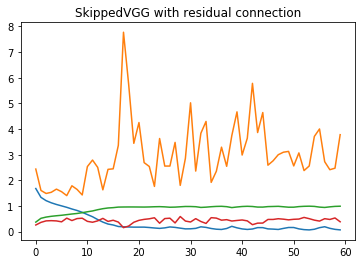

In [21]:
plt.title('SkippedVGG with residual connection')
plt.plot(hist), best_acc

## Heatmap visualization

In [12]:
import cv2

def attention(model, img, lb=None, visual_heatmap=True):
    model.eval()
    output = model(img.unsqueeze(0))
    prob = nn.Softmax()(output.detach())
    prob = float(prob.max(1)[0][0])
    
    
    pred_lb = int(output.argmax(1)[0])
    
    lb = pred_lb if lb is None else lb
    output[:,lb].backward()

    # get gradient
    grads = gradients['last_conv'][0]
    
    # !!! 2 options
#     pooled_grads = torch.mean(grads, dim=[0, 2, 3])
    pooled_grads = torch.nn.functional.adaptive_avg_pool2d(grads, (1, 1))

    # get activation
    features = activation['last_conv']

    # weight the channels by corresponding gradients
    for i in range(features.size(1)):
        features[:, i, :, :] *= pooled_grads[0,i,:,:]
   
    heatmap = features.detach().numpy()
    heatmap = np.mean(heatmap, axis=1).squeeze()
    
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)
    
 
    img = img.numpy()[0]
    img = np.stack((img,)*3, axis=-1)
    
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0])) # Adjust the size of the heat map to be the same as the original image
    heatmap = np.uint8(255 * heatmap) # Convert the heat map to RGB format
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET) # Apply the heat map to the original image
    superimposed_img = heatmap * 0.008 + img # here 0.4 is the heat map intensity factor
        
    superimposed_img /= np.max(superimposed_img)
    
        
    return superimposed_img, pred_lb, int(lb), prob
#         cv2.imwrite(save_path, superimposed_img)

In [7]:
!python '../utils/visualize_heatmap.py'

In [8]:
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

gradients = {}
def get_gradient(name):
    def hook(model, in_grad, out_grad):
        gradients[name] = out_grad
        
    return hook

In [9]:
images, labels = next(iter(test_loader))[:40]

### SkippedVGG 3 blocks

In [10]:
model = torch.load('/tf/data/Quan/fer2013/backtobasics/skippedvgg_3blocks.pt')
model = model.cpu()
model.eval()

model.sv2.convs[-1][-2].register_forward_hook(get_activation('last_conv'))
model.sv2.convs[-1][-2].register_backward_hook(get_gradient('last_conv'))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for

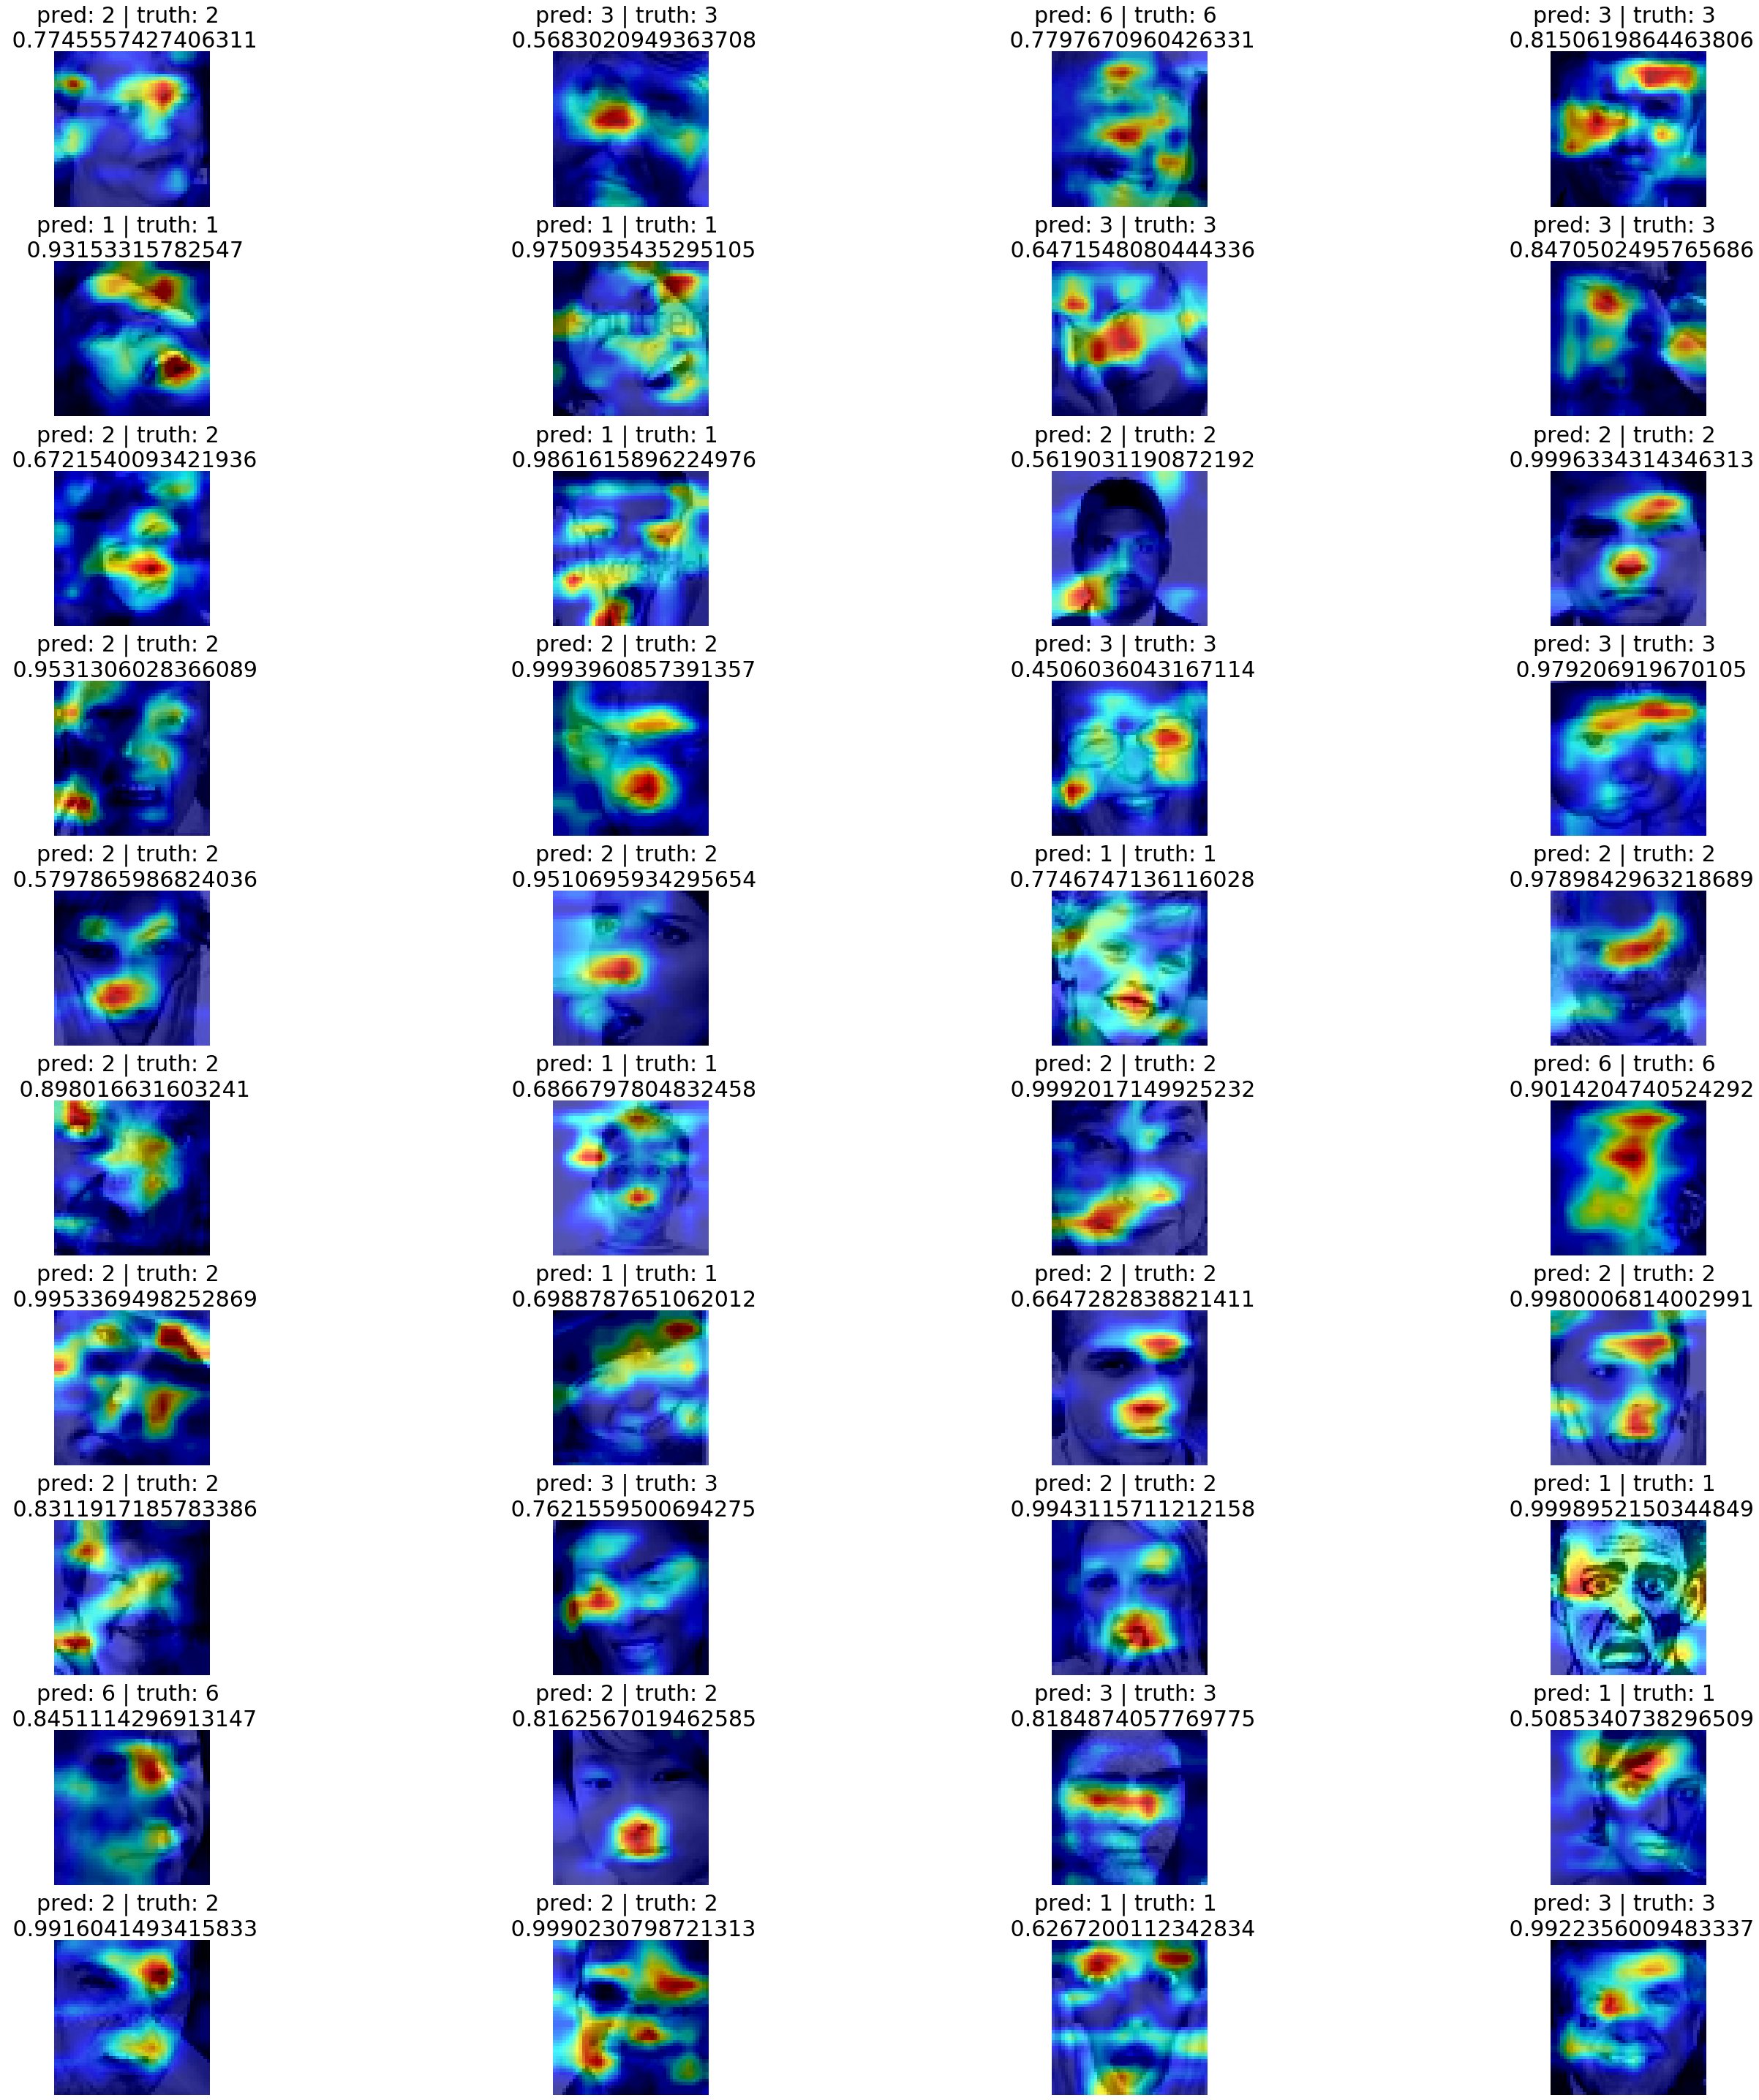

In [13]:
%matplotlib inline


# rows = len(labels) // 4 + 1
rows = 10
cols = 4
fig, axs = plt.subplots(rows, cols, figsize=(40,40))

id = 0

for i in range(rows):
    for j in range(cols):
        try:
            map, pred, truth, prob = attention(model, images[id], None, False)
            
            axs[i,j].imshow(map[:,:,[2,1,0]])
            axs[i,j].set_title('pred: ' + str(pred) + ' | truth: ' + str(truth) + ' \n ' + str(prob), size=30)
            axs[i,j].axis('off')
            id = id + 1
        except:
            break

plt.tight_layout()
plt.show()

### SkippedVGG with residual

In [17]:
model = torch.load('/tf/data/Quan/fer2013/backtobasics/skippedvgg_3blocks_residual.pt')

model = model.cpu()
model.eval()

model.sv2.convs[-1][-2].register_forward_hook(get_activation('last_conv'))
model.sv2.convs[-1][-2].register_backward_hook(get_gradient('last_conv'))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for

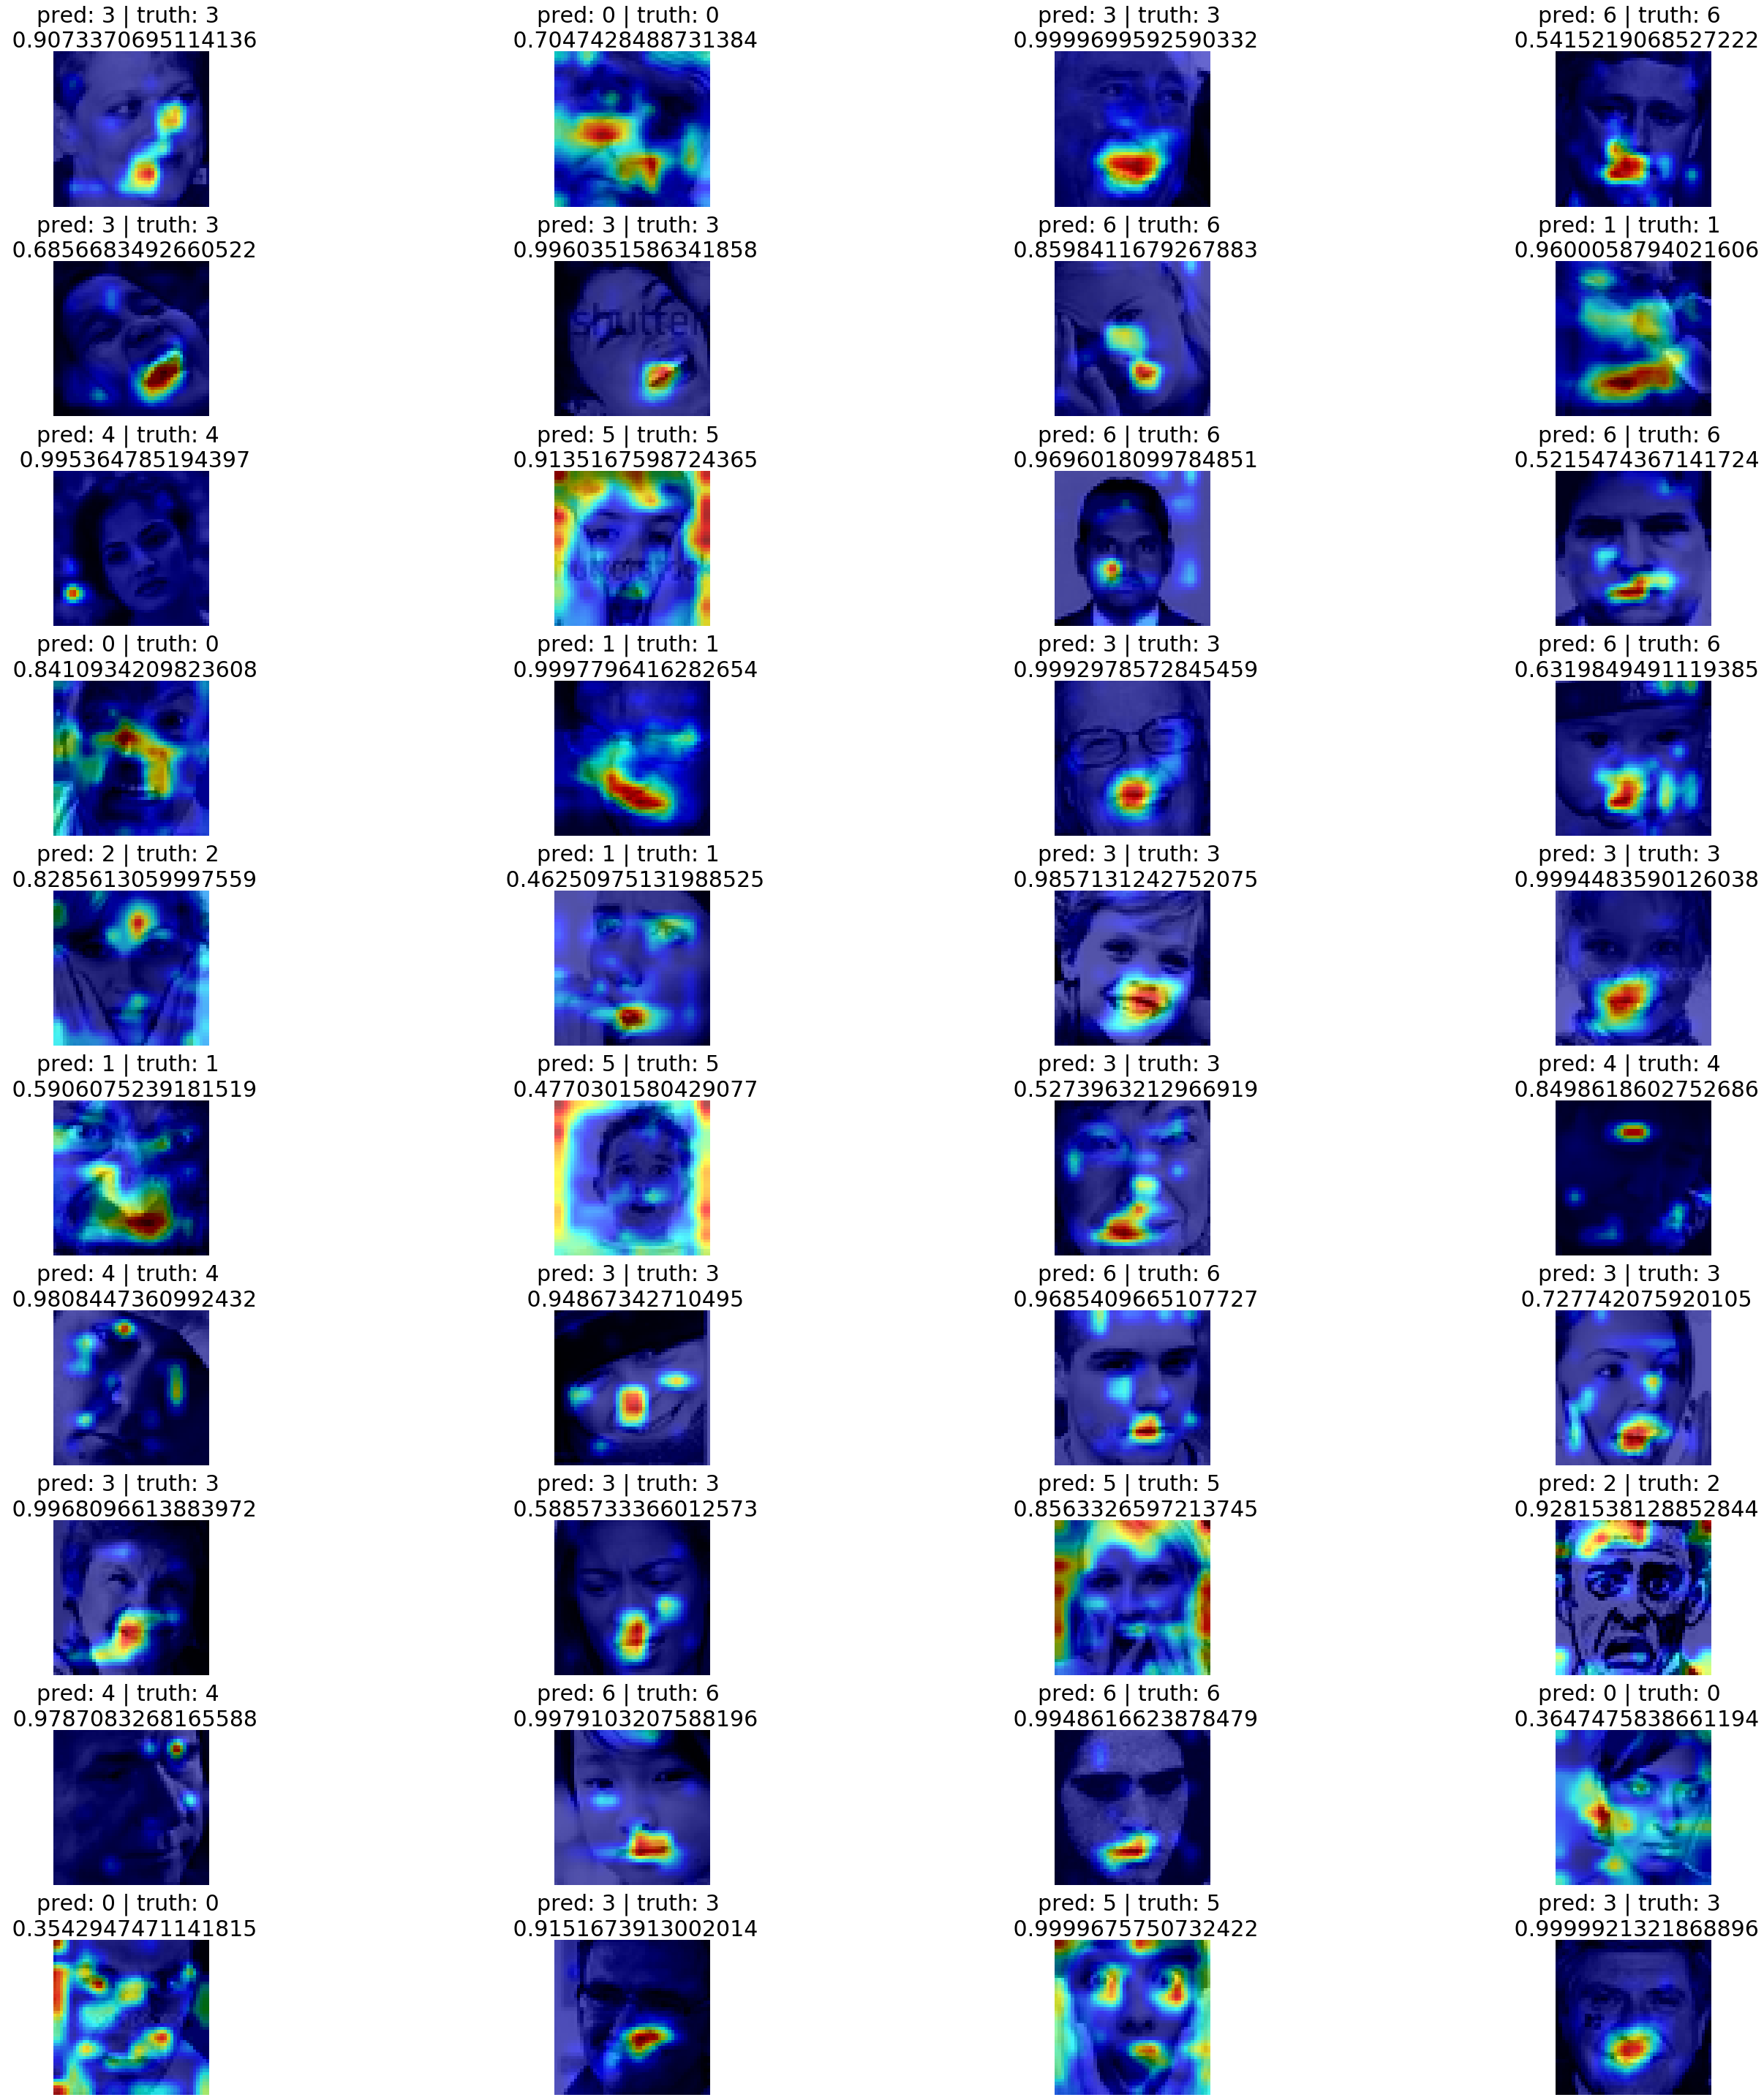

In [18]:
%matplotlib inline


# rows = len(labels) // 4 + 1
rows = 10
cols = 4
fig, axs = plt.subplots(rows, cols, figsize=(40,40))

id = 0

for i in range(rows):
    for j in range(cols):
        try:
            map, pred, truth, prob = attention(model, images[id], None, False)
            
            axs[i,j].imshow(map[:,:,[2,1,0]])
            axs[i,j].set_title('pred: ' + str(pred) + ' | truth: ' + str(truth) + ' \n ' + str(prob), size=30)
            axs[i,j].axis('off')
            id = id + 1
        except:
            break

plt.tight_layout()
plt.show()